In [1]:
from __future__ import division
import numpy as np
from numpy.random import choice as np_choice
import random
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
pool_size = multiprocessing.cpu_count()

# ACO Implementation

In [2]:
# This implementation has been inspired by Lab 5 and 
# N. K. Singh and S. Baidya, 
# "A novel work for bin packing problem by ant colony optimization," 
# International Journal of Research in Engineering and Technology (IJRET), vol. 2, Special Issue 2, pp. 71–73, Dec. 2013. [

class AntColony(object):
    """
    Implement ACO (Ant Colony Optimization) algorithm.
    """

    def __init__(self, num_items, items, capacity, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Initialize ACO instance.
        
        :param num_items: Number of items to be added to bins.
        :param items: Specifies the item sizes to be added to bins.
        :param capacity: Total capacity of one bin.
        :param n_ants: Number of ants running per iteration
        :param n_best: Number of best ants who deposit pheromone.
        :param decay: Rate at which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to slow decay, 0.5 to much faster decay.
        :param alpha: exponent on pheromone, higher alpha gives pheromone more weight. Default=1
        :param beta: exponent on load capacity, higher beta gives load capacity more weight. Default=1

        """
        self.num_items = num_items
        self.items = items
        self.capacity = capacity
        self.pheromone = np.ones((self.num_items, self.num_items))

        self.all_inds = range(num_items)
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta
        
        self.all_time_best = None
        self.best_bins_history = []
        self.final_loads = []

    def run(self, rng = None):
        """
        Runs the ACO algorithm.
        """
        if rng is None:
            rng = np.random

        shortest_path = None
        self.all_time_best = ("placeholder", np.inf)

        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths(rng)
            self.spread_pheromone(all_paths)
            shortest_path = min(all_paths, key=lambda x: x[1])

            if shortest_path[1] < self.all_time_best[1]:
                self.all_time_best = shortest_path
            
            self.best_bins_history.append(self.all_time_best[1])
            self.final_loads = self.all_time_best[2]
            self.pheromone = self.pheromone * self.decay
            
    
    def gen_path(self, rng=None):
        """
        Generates a single ant's path through the items for the bin packaging problem. 

        :return path: Sequence of (current_item, next_item) representing the ant's path.
        :return num_bins: Number of bins needed for the ant's path.
        :return bin_weights: The total weight of items in each bin.
        """

        if rng is None:
            rng = np.random

        remaining_items = set(range(self.num_items)) # Remaining items contains all items initially
        path = [] # Stores edges showing path links between items
        num_bins = 0 # Number of bins
        bin_weights = [] # Weights of items in bins

        while remaining_items:
            num_bins += 1 # Increase bin number
            current_weight = 0 # Initially bin is empty
            current_bin = [] # Initially bin is empty

            
            feasible = [i for i in remaining_items if self.items[i] <= self.capacity] # Select feasible items for this bin
            
            # If no feasible items, move to the next bin
            if not feasible:
                break

            
            
            current = rng.choice(feasible)
            # current = np_choice(feasible) # Pick a feasible item
            remaining_items.remove(current) # Remove picked item from remaining items 
            current_bin.append(current) # Add picked item to the current bin
            current_weight += self.items[current] # Add item size to the weight of the current bin

            # Keep adding items until bin is full
            while True:
                
                feasible = [j for j in remaining_items if current_weight + self.items[j] <= self.capacity]

                if not feasible:
                    break

                probs = []
                for j in feasible:
                    # Pheromone value
                    if not current_bin:
                        tau_bj = 1
                    else:
                        tau_bj = sum(self.pheromone[j, i] for i in current_bin) / len(current_bin)

                    
                    eta_j = (self.capacity - (current_weight + self.items[j])+1e-6) / self.capacity # Heuristic desirability (how well the item fits)

                    # Probability of adding this item
                    probs.append((tau_bj ** self.alpha) * (eta_j ** self.beta))
                
               
                probs = np.array(probs) / np.sum(probs) # Probabilities
                #next_item = np_choice(feasible, p=probs) # Pick next item
                next_item = rng.choice(feasible, p=probs)


                path.append((current, next_item)) # Add edge between current and next item in path

                current_bin.append(next_item) # Add next item to current bin
                remaining_items.remove(next_item) # Remove next item from remaining items
                current_weight += self.items[next_item] # Add next item to the weight of the current bin
                current = next_item # Set current to next item 

            bin_weights.append(current_weight) # Append total weight of current bin to bin weights

        return path, num_bins, bin_weights


    def gen_all_paths(self, rng = None):
        """
        Generating all paths for all ants.

        :return all_paths: Contains path, number of bins, and bin weights for all ants.
        """
        if rng is None:
            rng = np.random

        all_paths = []
        for i in range(self.n_ants):
            path, num_bins, bin_weight = self.gen_path(rng = rng)
            all_paths.append((path, num_bins, bin_weight))
        return all_paths
    
    def fitness(self, num_bins, bin_weights):
        """
        Used to update pheromones. Shows the amount of pheromones a single ant deposits. Based on function shown in referenced paper.

        :param num_bins: Number of bins in path.
        :param bin_weights: Total weights for bins in path.

        :return the amount of pheromones a single ant deposits.

        """

        
        m = 2
        return (1 / num_bins) * sum((w / self.capacity) ** m for w in bin_weights)

    def spread_pheromone(self, all_paths):
        """
        Spreads pheromones for all paths.

        :param all_paths: Contains paths, number of bins and bin weights for all ants.
        """

        for path, num_bins, bin_weights in all_paths[:self.n_best]:
            delta_tau = self.fitness(num_bins, bin_weights)
            for bin_items in path:  
                for i in bin_items:
                    for j in bin_items:
                        if i != j:
                            self.pheromone[i,j] += delta_tau
    


# Running the ACO algorithm.

The algorithm will be ran on 8 problems selected from the Data/1_D Bin Packing folder

### Helper Function to Read Data from Files

In [3]:
# Function to read a local bin packing instance

def read_binpack_file(filename):
    """
    Reads a 1-D bin packing instance from a local text file.
    
    File format:
    Line 1: Number of items (n)
    Line 2: Box capacity (C)
    Line 3: Item sizes separated by spaces
    
    Returns:
    - num_items: int
    - box_capacity: int
    - items: list of ints
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    test_problems = lines[0]
    instances = {}
    i = 1
    while i < len(lines):
        if "u" in lines[i] or "t" in lines[i]:
            id = lines[i]
            i+=1
            bin_capacity, num_items, best_known_bins = lines[i].split()
            
            i+=1
            item_sizes = [float(lines[i + j].strip()) for j in range(int(num_items))]
            i += int(num_items)
            instances[id] = {
                "bin_capacity": int(float(bin_capacity)),
                "num_items": int(num_items),
                "best_known_bins": int(best_known_bins),
                "item_sizes": item_sizes
            }
    return instances

### Helper Function to Execute Runs in Parallel

In [4]:
# Helper function to for parallel execution

def run_aco(aco, seed):
    """
    Runs an ACO instance with a given random seed. 
    Used for parallel execution.

    :param pso: PSO instance.
    :param seed: Seed for random generator for ensuring reproducibility.
    
    :return: PSO instance after execution.
    """

    rng = np.random.RandomState(seed)
    aco.run(rng)
    return aco

### Helper Function to Execute Runs

In [5]:
import time
def run_plot_ACO(num_items, capacity, items, n_ants, n_best, n_iterations, decay, alpha, beta, n_runs):
    start_time = time.time()

    results = [] # Used for parallel execution

    all_runs = [] # Results for each run

    with multiprocessing.Pool(processes=pool_size) as pool:
        for run in range(n_runs):
            
            random.seed(run)

            aco = AntColony(num_items=num_items, capacity=capacity, items=items, n_ants = n_ants, n_best = n_best, n_iterations = n_iterations, decay = decay, alpha = alpha, beta = beta)
            res = pool.apply_async(run_aco, (aco,run,))
            results.append(res)
        for result in [res.get() for res in results]:
            run_result = {
                'best_solution': result.all_time_best,
                'best_bins_history': np.array(result.best_bins_history),
                'final_loads': result.final_loads
                                        }
            all_runs.append(run_result)

    # Compute Statistics 
    # Get final number of bins for each run
    final_bins = np.array([run['best_solution'][1] for run in all_runs])
    mean_final_bins = np.mean(final_bins) # Mean of final bins
    median_final_bins = np.median(final_bins) # Median of final bins
    best_final_bins = np.min(final_bins) # Best final bins
    worst_final_bins= np.max(final_bins) # Worst final bins
    std_dev_final_bins = np.std(final_bins) # Standard deviation 

    print("Mean number of final bins", mean_final_bins)
    print("Median number of final bins", median_final_bins)
    print("Best number of final bins", best_final_bins)
    print("Worst number of final bins", worst_final_bins)
    print("Standard deviation", std_dev_final_bins)





    all_histories_bins = np.array([run['best_bins_history'] for run in all_runs])
    mean_histories_bins = np.mean(all_histories_bins, axis=0)
    std_histories_bins = np.std(all_histories_bins, axis=0)


    plt.plot(mean_histories_bins, label='Mean Number of Bins')
    plt.fill_between(range(len(mean_histories_bins)), 
                    mean_histories_bins - std_histories_bins,
                    mean_histories_bins + std_histories_bins,
                    alpha=0.2, label='Standard Deviation')
    plt.xlabel('Iteration')
    plt.ylabel('Best Number of Bins')
    plt.title('Convergence Plot (20 runs)')
    plt.legend()
    plt.show()


    # Get final unused capacity
    final_loads = [run['final_loads'] for run in all_runs]
    unused_capacity_per_run = [np.sum(capacity - np.array(loads)) for loads in final_loads]
    mean_unused = np.mean(unused_capacity_per_run) # Mean of final bins
    median_unused = np.median(unused_capacity_per_run) # Median of final bins
    best_unused = np.min(unused_capacity_per_run) # Best final bins
    worst_unused = np.max(unused_capacity_per_run) # Worst final bins
    std_dev_unused = np.std(unused_capacity_per_run) # Standard deviation 

    print("Mean number of unused capacity ", mean_unused)
    print("Median number of unused capacity", median_unused)
    print("Best number of unused capacity", best_unused)
    print("Worst number of unused capacity", worst_unused)
    print("Standard deviation of unused capacity", std_dev_unused)

    print("\n\nLoad Distribution for the best solution")


    best_loads = []
    for idx, bins in enumerate(final_bins):
        if bins == best_final_bins:
            best_loads = final_loads[idx]
            unused_capacity = np.sum(capacity - np.array(best_loads))
            print("The unused capacity for best solution", unused_capacity)
            plt.hist(np.array(best_loads)/capacity, bins = 'auto')
            plt.xlabel("Bin Utilization (load / capacity)")
            plt.ylabel("Frequency")
            plt.title("Load Distribution Across Bins (All Runs)")
            plt.grid(True, alpha=0.3)
            plt.show()

            plt.bar(range(len(best_loads)), np.array(best_loads)/capacity)
            plt.xlabel("Bin Index")
            plt.ylabel("Utilization (load / capacity)")
            plt.title("Bin Utilization per Bin (Best Run)")
            plt.show()
            break
    end_time = time.time()
    runtime = end_time - start_time
    print(f"Total runtime for {n_runs} runs: {runtime:.2f} seconds")


## Problem #1

In [6]:
# Get the data


filename = "Data/1-D Bin Packing /binpack1.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[0]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  150
Number of items:  120


Mean number of final bins 53.2
Median number of final bins 53.0
Best number of final bins 52
Worst number of final bins 54
Standard deviation 0.5099019513592784


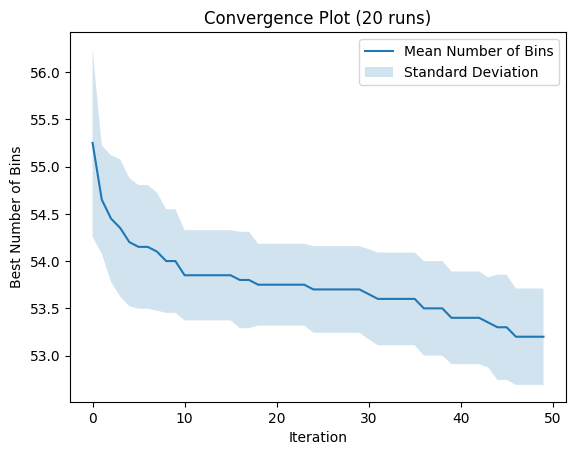

Mean number of unused capacity  902.0
Median number of unused capacity 872.0
Best number of unused capacity 722.0
Worst number of unused capacity 1022.0
Standard deviation of unused capacity 76.48529270389177


Load Distribution for the best solution
The unused capacity for best solution 722.0


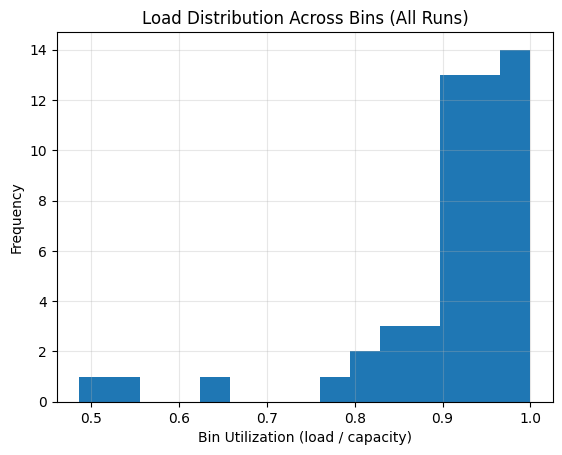

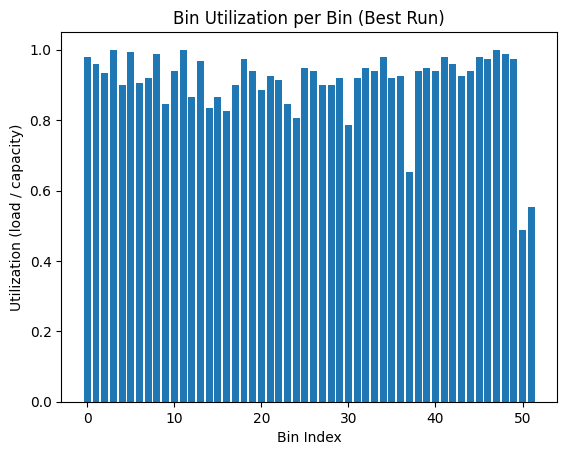

Total runtime for 20 runs: 1.52 seconds


In [7]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #1

Mean number of final bins 52.95
Median number of final bins 53.0
Best number of final bins 52
Worst number of final bins 54
Standard deviation 0.38405728739343037


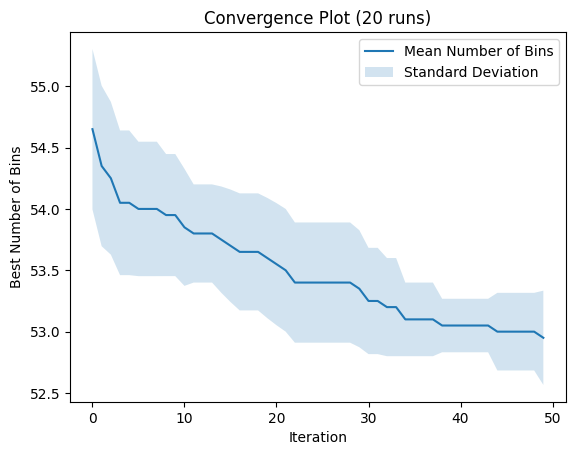

Mean number of unused capacity  864.5
Median number of unused capacity 872.0
Best number of unused capacity 722.0
Worst number of unused capacity 1022.0
Standard deviation of unused capacity 57.60859310901456


Load Distribution for the best solution
The unused capacity for best solution 722.0


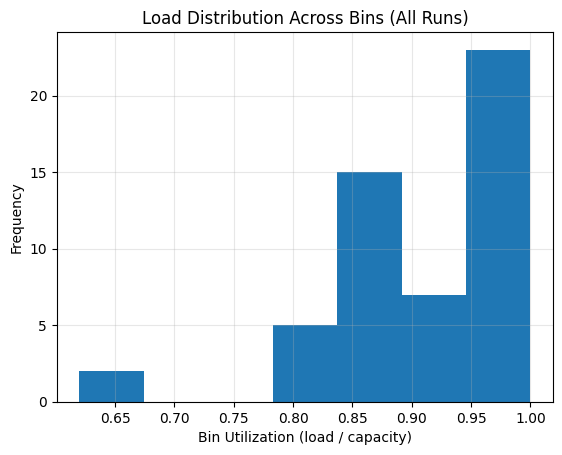

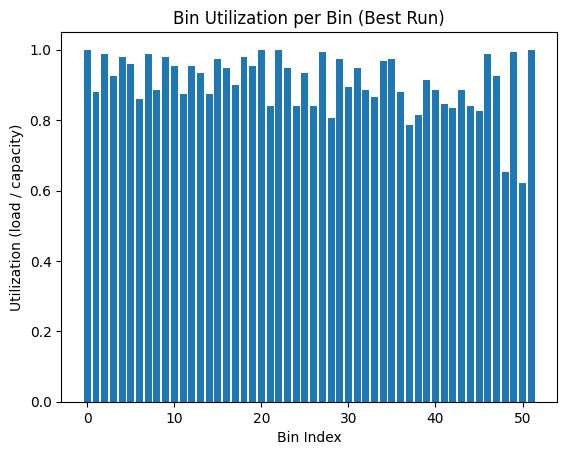

Total runtime for 20 runs: 3.91 seconds


In [8]:
# 15 ants with 5 best

run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)


### Increase Iterations #1

Mean number of final bins 52.85
Median number of final bins 53.0
Best number of final bins 52
Worst number of final bins 54
Standard deviation 0.47696960070847283


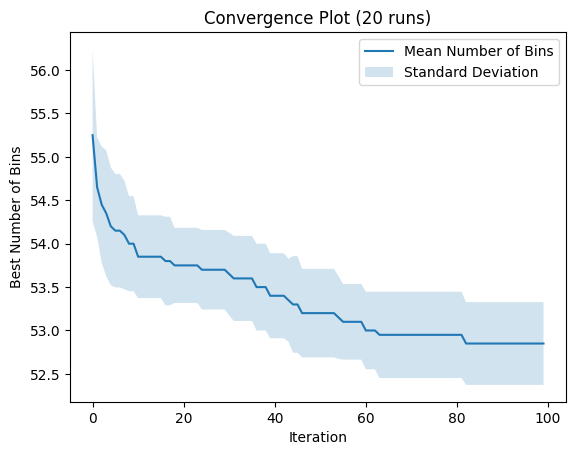

Mean number of unused capacity  849.5
Median number of unused capacity 872.0
Best number of unused capacity 722.0
Worst number of unused capacity 1022.0
Standard deviation of unused capacity 71.54544010627092


Load Distribution for the best solution
The unused capacity for best solution 722.0


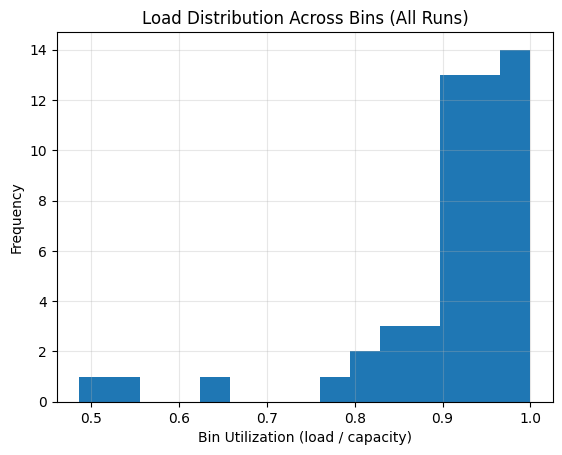

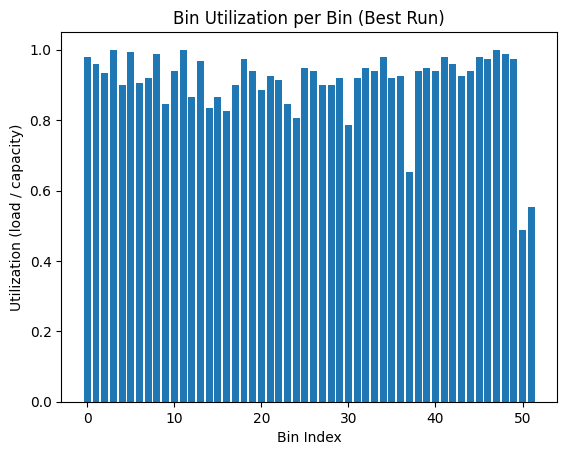

Total runtime for 20 runs: 2.79 seconds


In [9]:
## Increase Iterations

run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #1

Mean number of final bins 51.9
Median number of final bins 52.0
Best number of final bins 51
Worst number of final bins 53
Standard deviation 0.5385164807134505


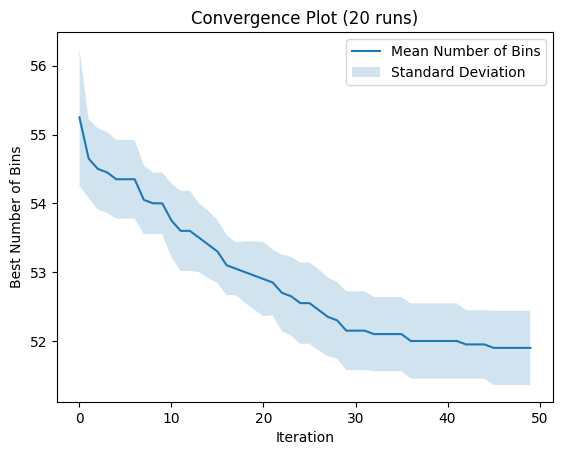

Mean number of unused capacity  707.0
Median number of unused capacity 722.0
Best number of unused capacity 572.0
Worst number of unused capacity 872.0
Standard deviation of unused capacity 80.77747210701756


Load Distribution for the best solution
The unused capacity for best solution 572.0


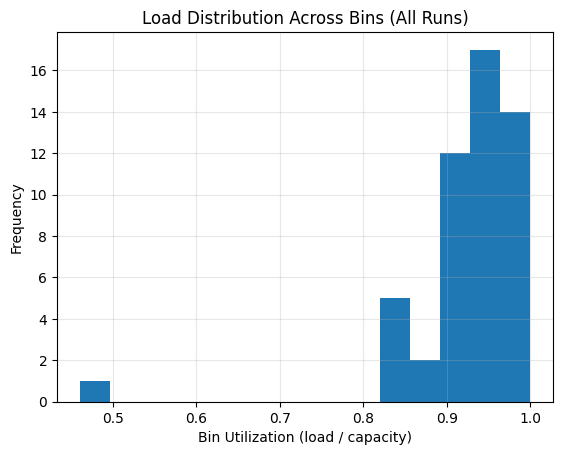

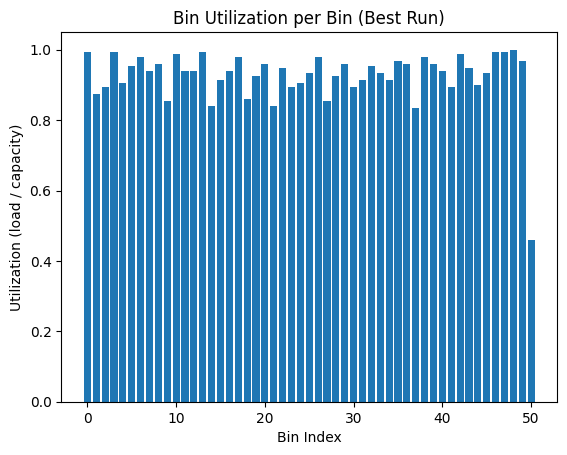

Total runtime for 20 runs: 1.48 seconds


In [10]:

run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #1




Alpha Value: 0.5
Mean number of final bins 53.45
Median number of final bins 53.5
Best number of final bins 52
Worst number of final bins 54
Standard deviation 0.5894913061275798


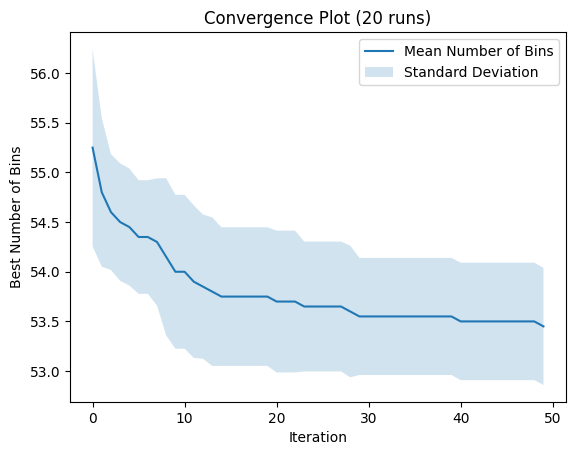

Mean number of unused capacity  939.5
Median number of unused capacity 947.0
Best number of unused capacity 722.0
Worst number of unused capacity 1022.0
Standard deviation of unused capacity 88.42369591913697


Load Distribution for the best solution
The unused capacity for best solution 722.0


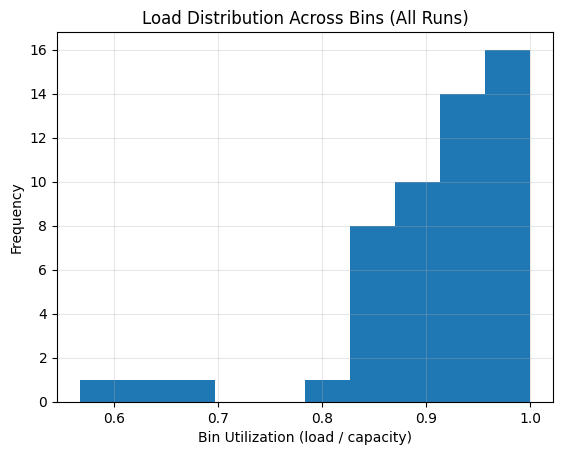

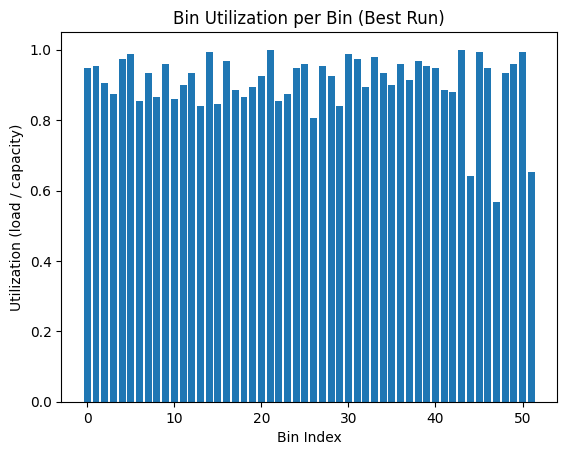

Total runtime for 20 runs: 1.43 seconds



Alpha Value: 2
Mean number of final bins 52.4
Median number of final bins 52.0
Best number of final bins 52
Worst number of final bins 53
Standard deviation 0.48989794855663565


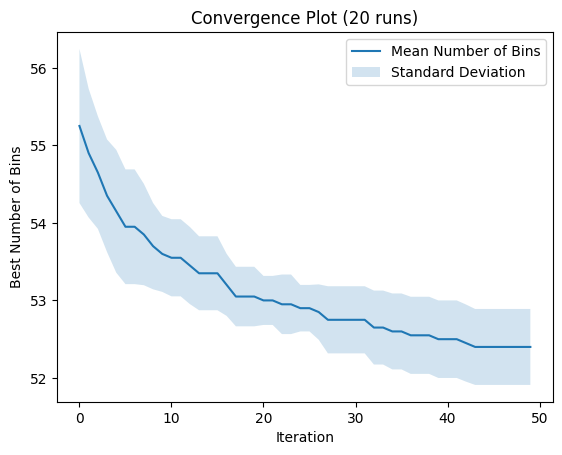

Mean number of unused capacity  782.0
Median number of unused capacity 722.0
Best number of unused capacity 722.0
Worst number of unused capacity 872.0
Standard deviation of unused capacity 73.48469228349535


Load Distribution for the best solution
The unused capacity for best solution 722.0


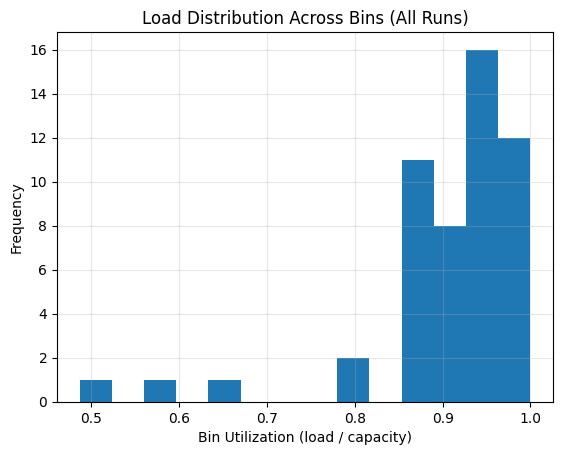

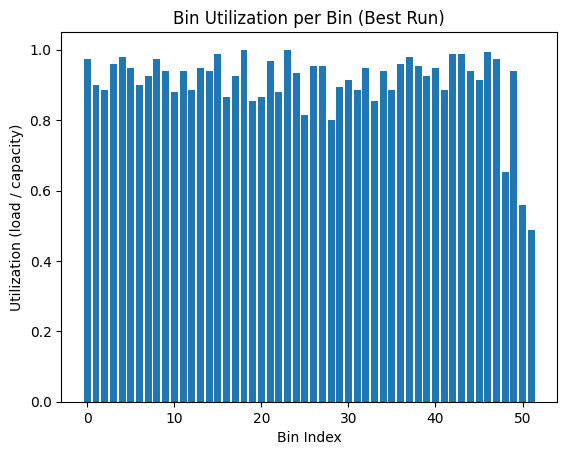

Total runtime for 20 runs: 1.48 seconds


In [11]:


alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\nAlpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #1




Beta value is:  0.5
Mean number of final bins 52.0
Median number of final bins 52.0
Best number of final bins 51
Worst number of final bins 53
Standard deviation 0.31622776601683794


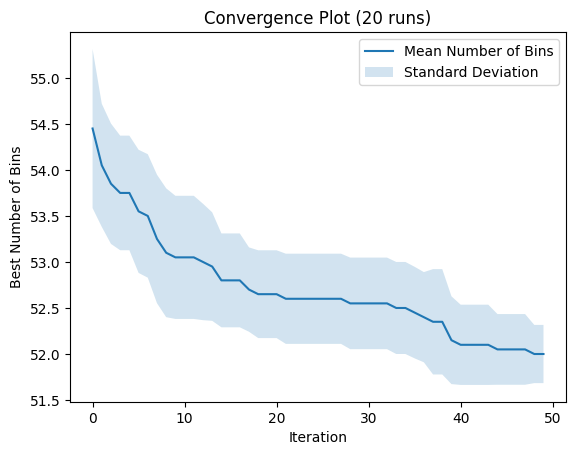

Mean number of unused capacity  722.0
Median number of unused capacity 722.0
Best number of unused capacity 572.0
Worst number of unused capacity 872.0
Standard deviation of unused capacity 47.43416490252569


Load Distribution for the best solution
The unused capacity for best solution 572.0


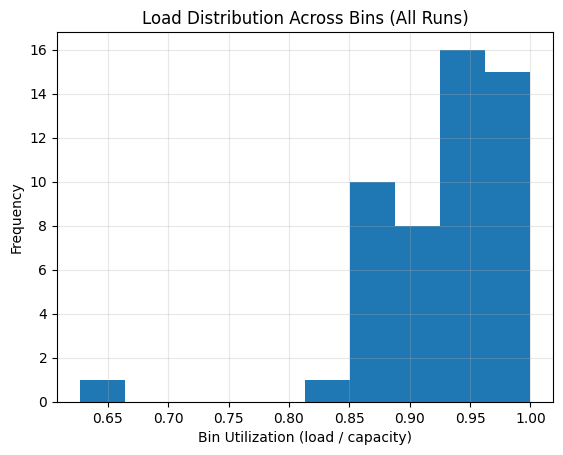

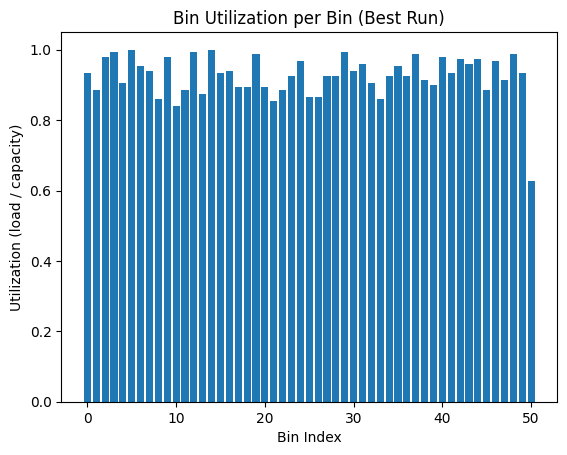

Total runtime for 20 runs: 1.45 seconds



Beta value is:  2
Mean number of final bins 54.75
Median number of final bins 55.0
Best number of final bins 54
Worst number of final bins 55
Standard deviation 0.4330127018922193


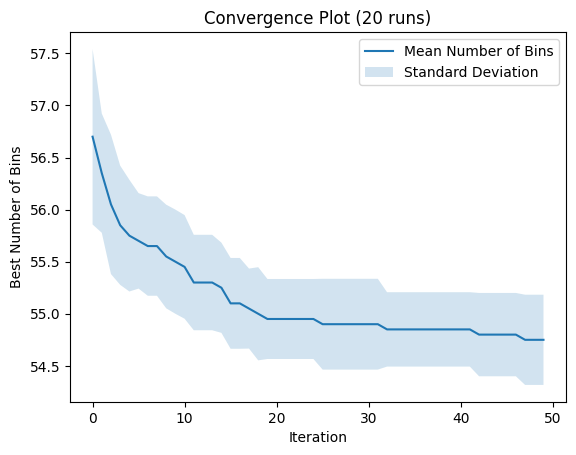

Mean number of unused capacity  1134.5
Median number of unused capacity 1172.0
Best number of unused capacity 1022.0
Worst number of unused capacity 1172.0
Standard deviation of unused capacity 64.9519052838329


Load Distribution for the best solution
The unused capacity for best solution 1022.0


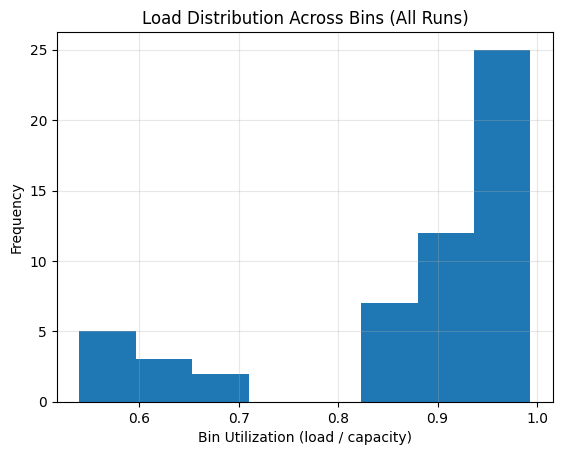

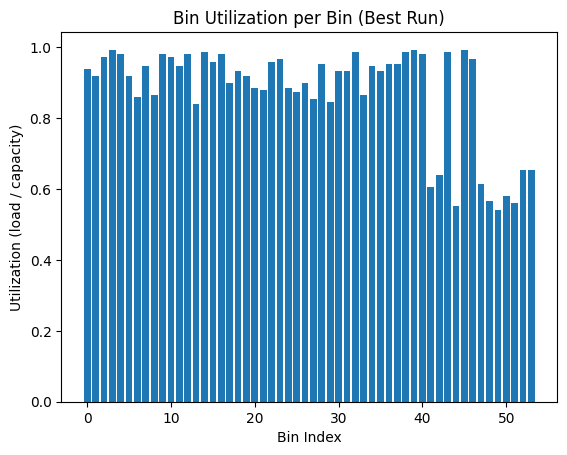

Total runtime for 20 runs: 1.43 seconds


In [12]:

betas = [0.5, 2]
for beta in betas:
    print("\n\n\nBeta value is: ", beta)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = beta, n_runs = 20)

    


# Problem #2

In [13]:
# Get the data


filename = "Data/1-D Bin Packing /binpack2.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[1]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]

print("Capacity: ", capacity)
print("Number of items: ", num_items)

Capacity:  150
Number of items:  250


Mean number of final bins 113.25
Median number of final bins 113.0
Best number of final bins 112
Worst number of final bins 114
Standard deviation 0.5361902647381804


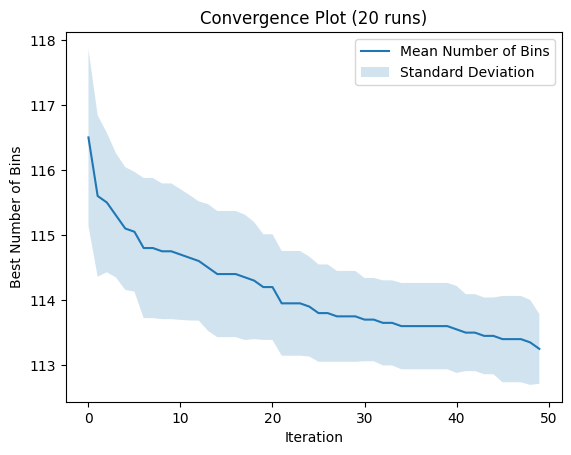

Mean number of unused capacity  2133.5
Median number of unused capacity 2096.0
Best number of unused capacity 1946.0
Worst number of unused capacity 2246.0
Standard deviation of unused capacity 80.42853971072707


Load Distribution for the best solution
The unused capacity for best solution 1946.0


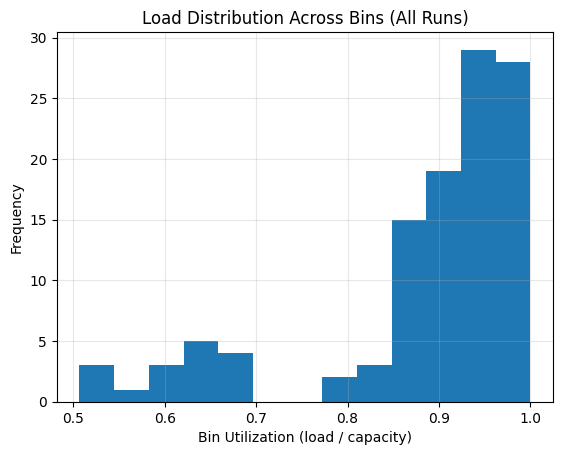

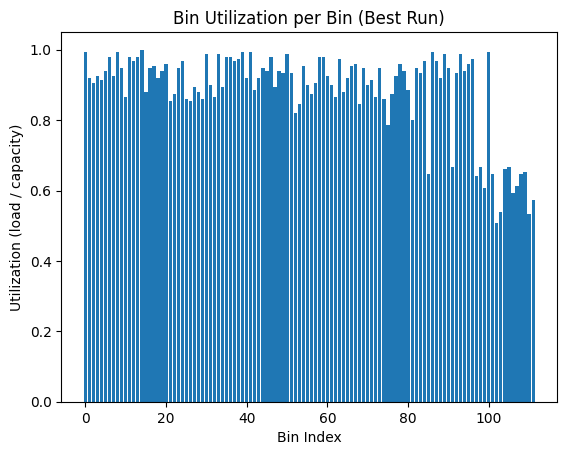

Total runtime for 20 runs: 4.42 seconds


In [14]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase No. of Ants #2

Mean number of final bins 112.7
Median number of final bins 113.0
Best number of final bins 112
Worst number of final bins 113
Standard deviation 0.45825756949558394


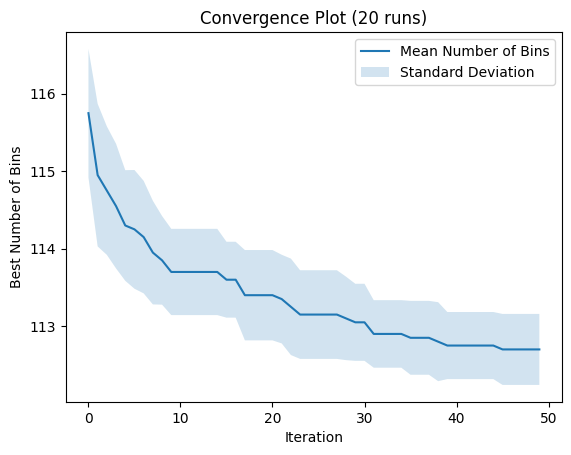

Mean number of unused capacity  2051.0
Median number of unused capacity 2096.0
Best number of unused capacity 1946.0
Worst number of unused capacity 2096.0
Standard deviation of unused capacity 68.7386354243376


Load Distribution for the best solution
The unused capacity for best solution 1946.0


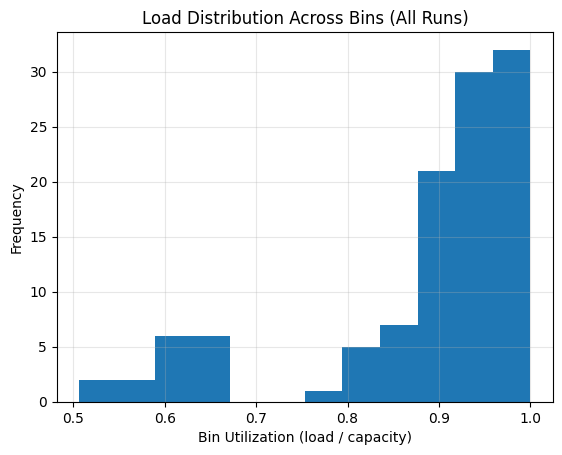

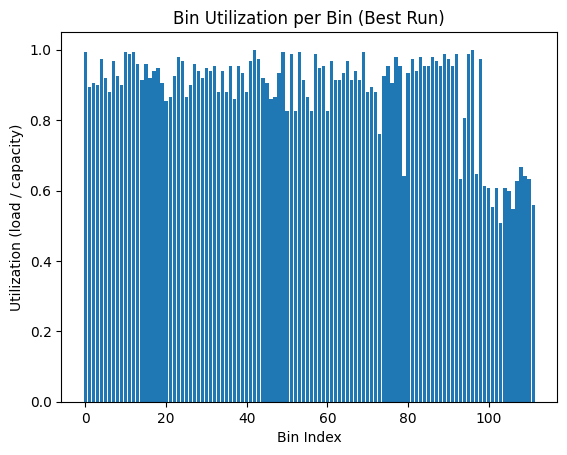

Total runtime for 20 runs: 12.86 seconds


In [15]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #2

Mean number of final bins 112.25
Median number of final bins 112.0
Best number of final bins 110
Worst number of final bins 113
Standard deviation 0.82915619758885


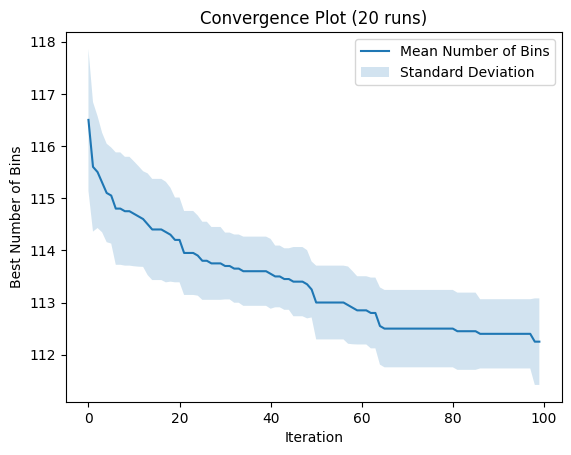

Mean number of unused capacity  1983.5
Median number of unused capacity 1946.0
Best number of unused capacity 1646.0
Worst number of unused capacity 2096.0
Standard deviation of unused capacity 124.3734296383275


Load Distribution for the best solution
The unused capacity for best solution 1646.0


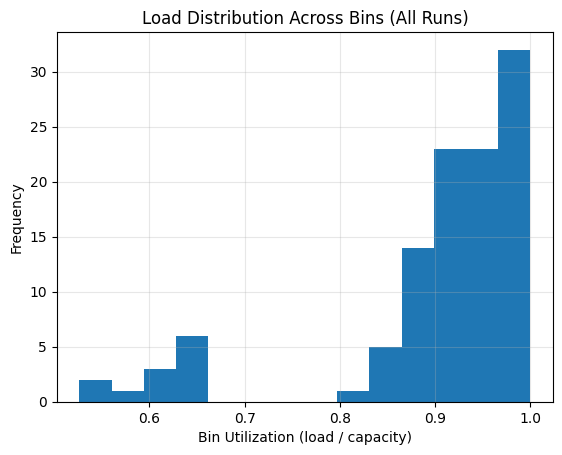

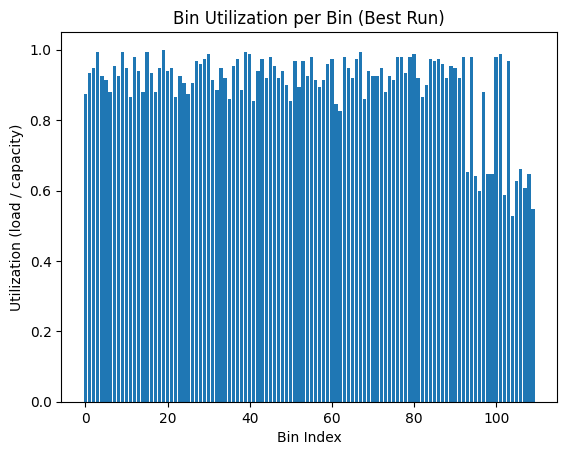

Total runtime for 20 runs: 9.09 seconds


In [16]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #2

Mean number of final bins 109.45
Median number of final bins 110.0
Best number of final bins 108
Worst number of final bins 110
Standard deviation 0.7399324293474371


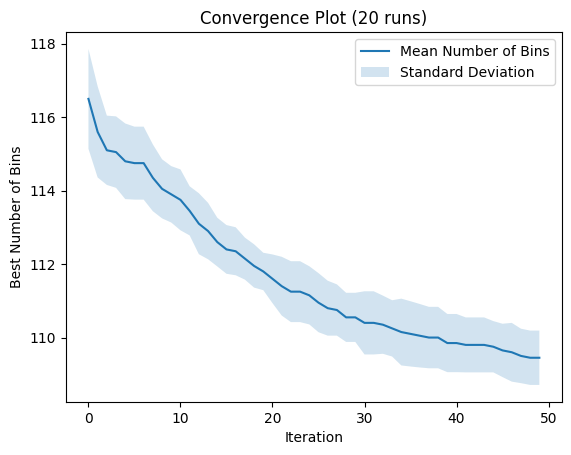

Mean number of unused capacity  1563.5
Median number of unused capacity 1646.0
Best number of unused capacity 1346.0
Worst number of unused capacity 1646.0
Standard deviation of unused capacity 110.98986440211557


Load Distribution for the best solution
The unused capacity for best solution 1346.0


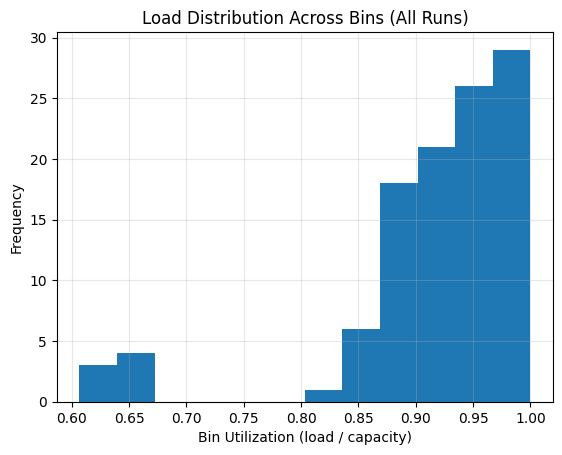

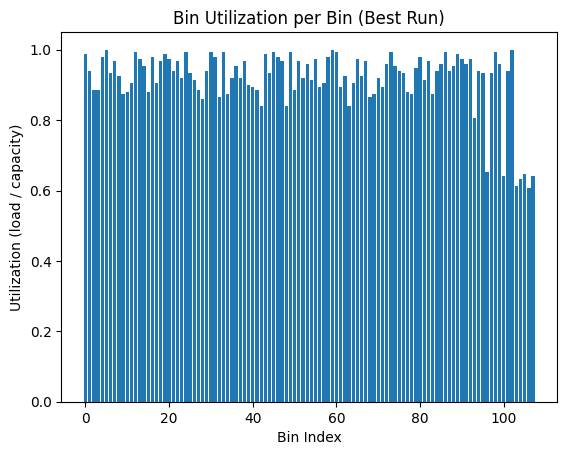

Total runtime for 20 runs: 4.82 seconds


In [17]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #2




Alpha Value: 0.5
Mean number of final bins 113.5
Median number of final bins 114.0
Best number of final bins 112
Worst number of final bins 115
Standard deviation 0.7416198487095663


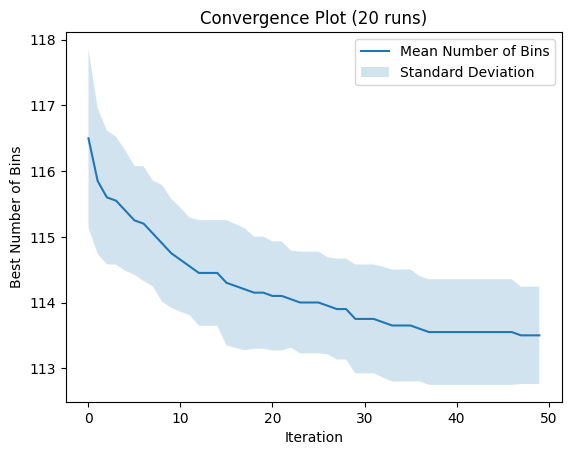

Mean number of unused capacity  2171.0
Median number of unused capacity 2246.0
Best number of unused capacity 1946.0
Worst number of unused capacity 2396.0
Standard deviation of unused capacity 111.24297730643494


Load Distribution for the best solution
The unused capacity for best solution 1946.0


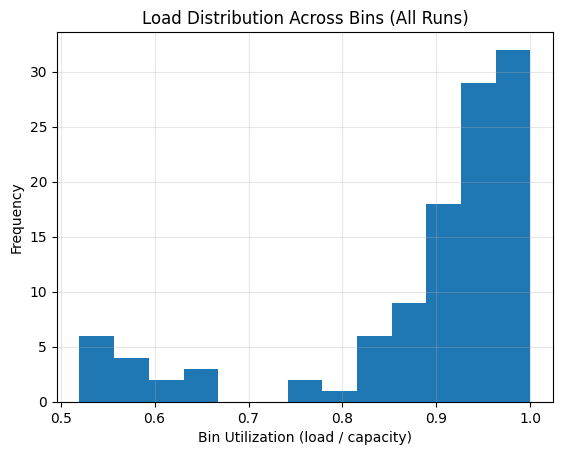

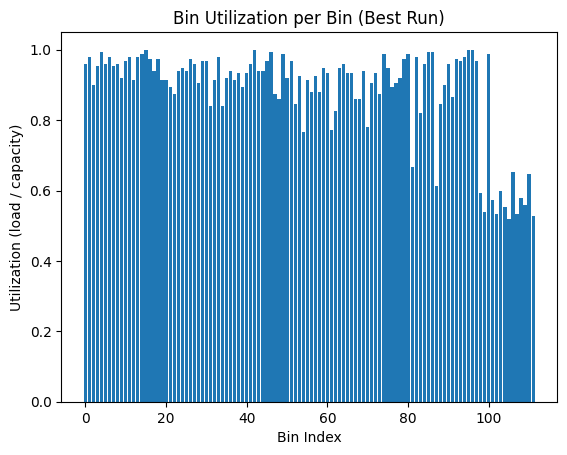

Total runtime for 20 runs: 5.14 seconds



Alpha Value: 2
Mean number of final bins 110.75
Median number of final bins 111.0
Best number of final bins 109
Worst number of final bins 112
Standard deviation 0.698212002188447


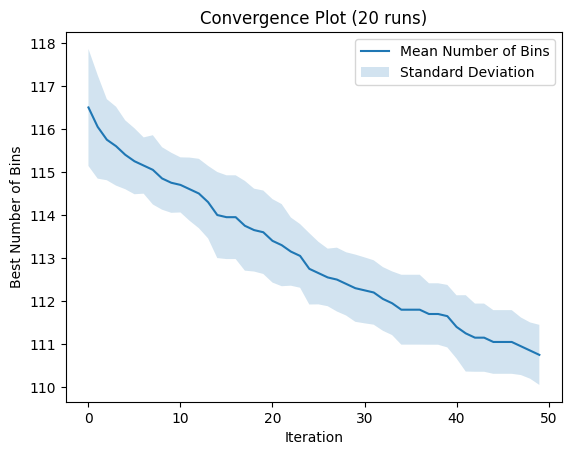

Mean number of unused capacity  1758.5
Median number of unused capacity 1796.0
Best number of unused capacity 1496.0
Worst number of unused capacity 1946.0
Standard deviation of unused capacity 104.73180032826706


Load Distribution for the best solution
The unused capacity for best solution 1496.0


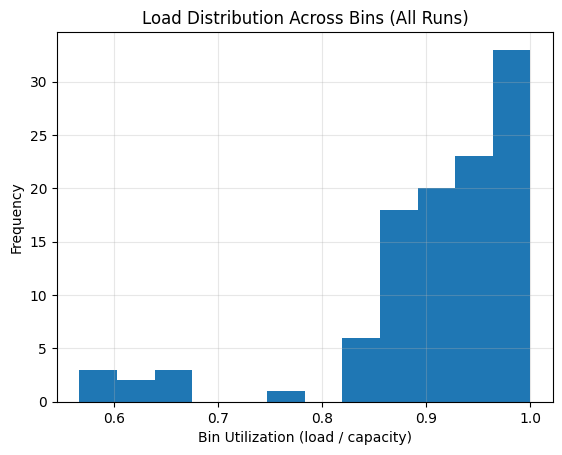

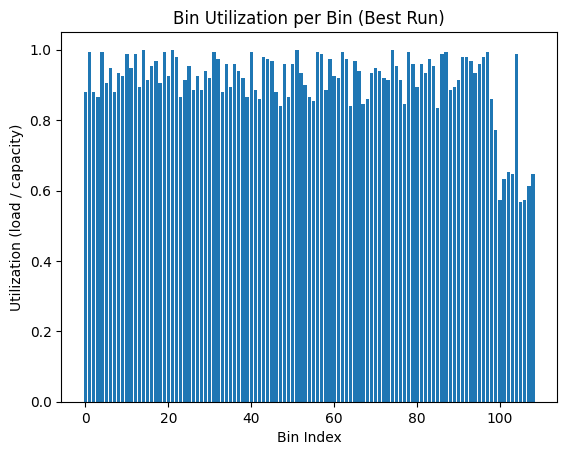

Total runtime for 20 runs: 5.85 seconds


In [18]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\nAlpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #2




Beta value is:  0.5
Mean number of final bins 110.7
Median number of final bins 111.0
Best number of final bins 110
Worst number of final bins 112
Standard deviation 0.6403124237432849


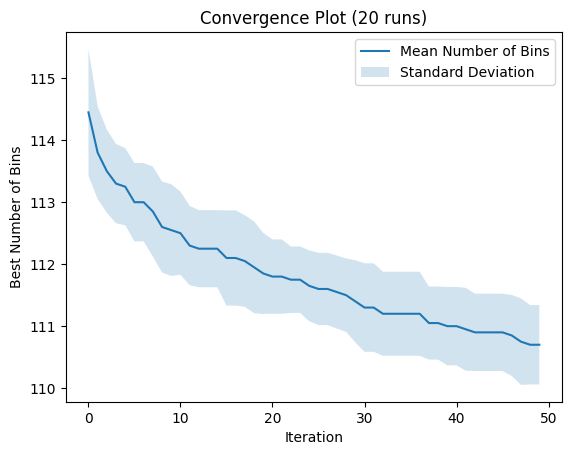

Mean number of unused capacity  1751.0
Median number of unused capacity 1796.0
Best number of unused capacity 1646.0
Worst number of unused capacity 1946.0
Standard deviation of unused capacity 96.04686356149273


Load Distribution for the best solution
The unused capacity for best solution 1646.0


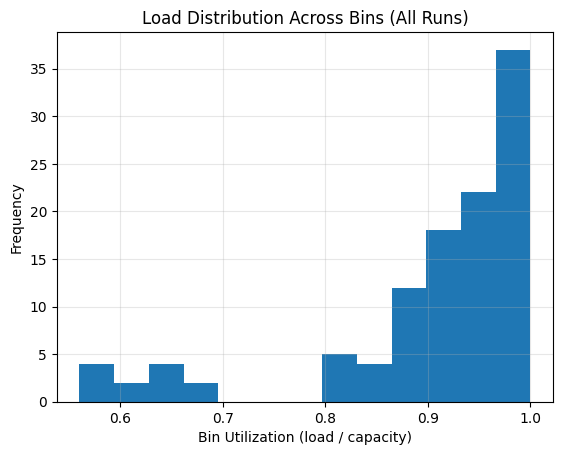

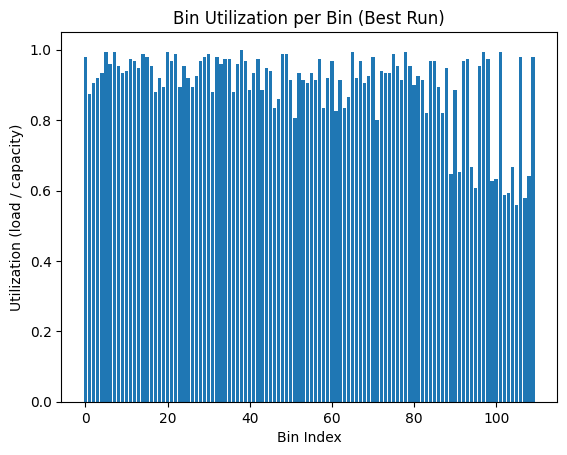

Total runtime for 20 runs: 4.51 seconds



Beta value is:  2
Mean number of final bins 116.0
Median number of final bins 116.0
Best number of final bins 114
Worst number of final bins 117
Standard deviation 0.7745966692414834


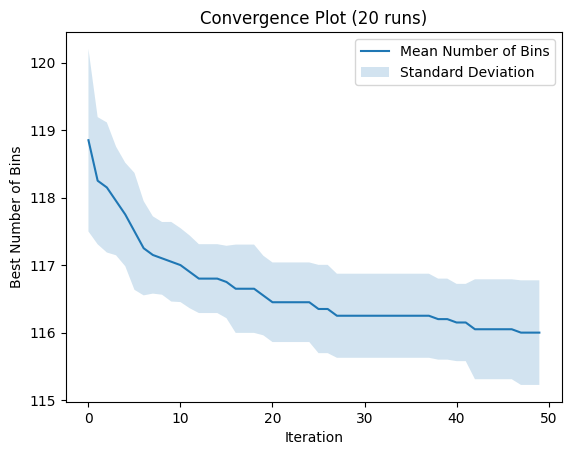

Mean number of unused capacity  2546.0
Median number of unused capacity 2546.0
Best number of unused capacity 2246.0
Worst number of unused capacity 2696.0
Standard deviation of unused capacity 116.1895003862225


Load Distribution for the best solution
The unused capacity for best solution 2246.0


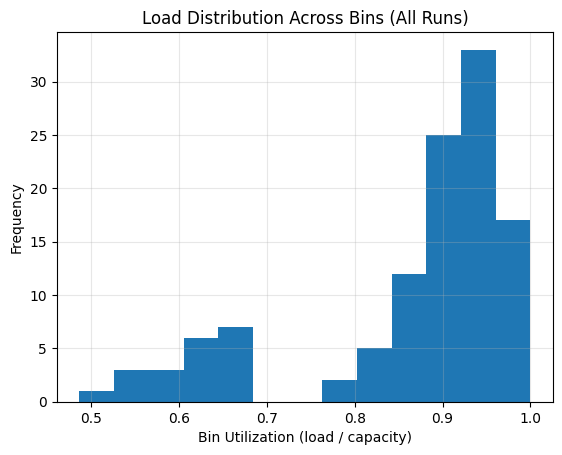

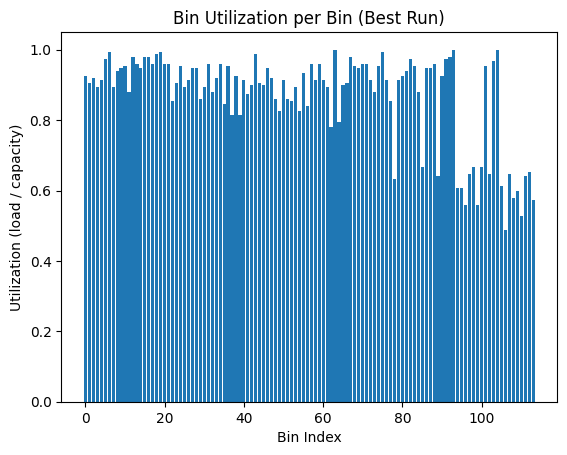

Total runtime for 20 runs: 4.38 seconds


In [19]:

betas = [0.5, 2]
for beta in betas:
    print("\n\n\nBeta value is: ", beta)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = beta, n_runs = 20)


## Problem #3

In [20]:
# Get the data


filename = "Data/1-D Bin Packing /binpack3.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[2]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  150
Number of items:  500


Mean number of final bins 231.05
Median number of final bins 231.0
Best number of final bins 229
Worst number of final bins 233
Standard deviation 0.9205976319760985


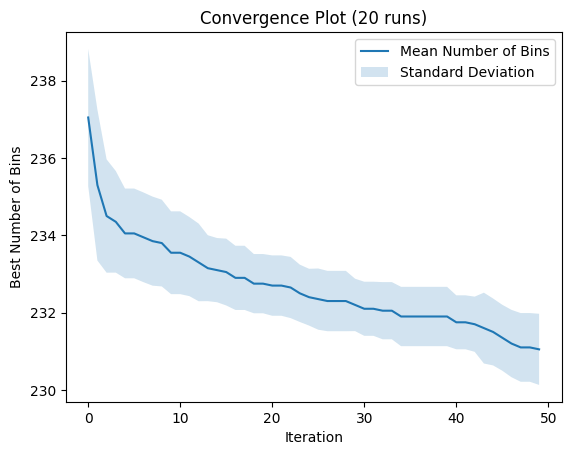

Mean number of unused capacity  4441.5
Median number of unused capacity 4434.0
Best number of unused capacity 4134.0
Worst number of unused capacity 4734.0
Standard deviation of unused capacity 138.08964479641477


Load Distribution for the best solution
The unused capacity for best solution 4134.0


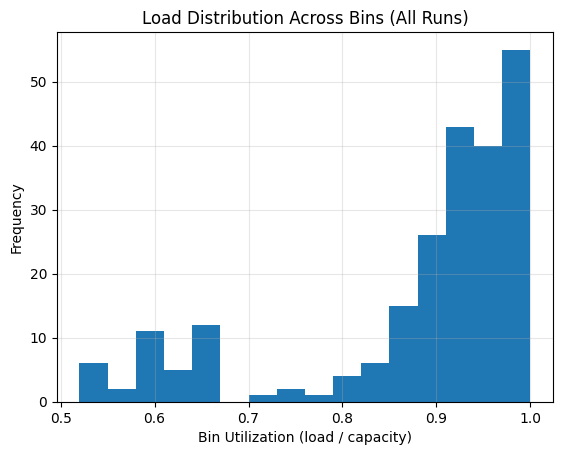

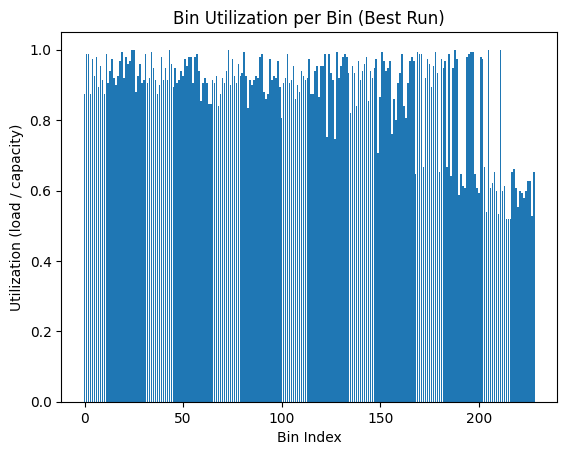

Total runtime for 20 runs: 15.48 seconds


In [21]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #3

Mean number of final bins 229.95
Median number of final bins 230.0
Best number of final bins 228
Worst number of final bins 231
Standard deviation 0.8645808232895291


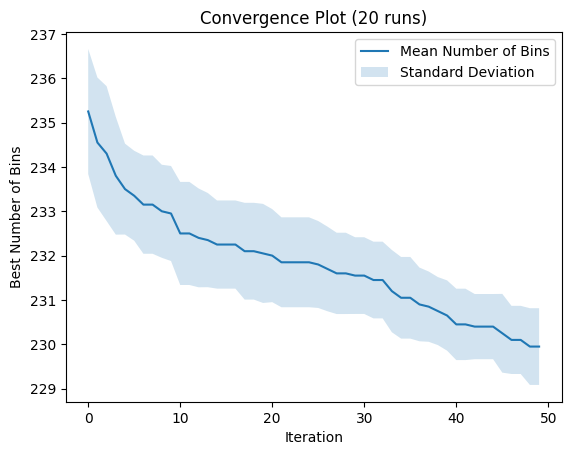

Mean number of unused capacity  4276.5
Median number of unused capacity 4284.0
Best number of unused capacity 3984.0
Worst number of unused capacity 4434.0
Standard deviation of unused capacity 129.68712349342937


Load Distribution for the best solution
The unused capacity for best solution 3984.0


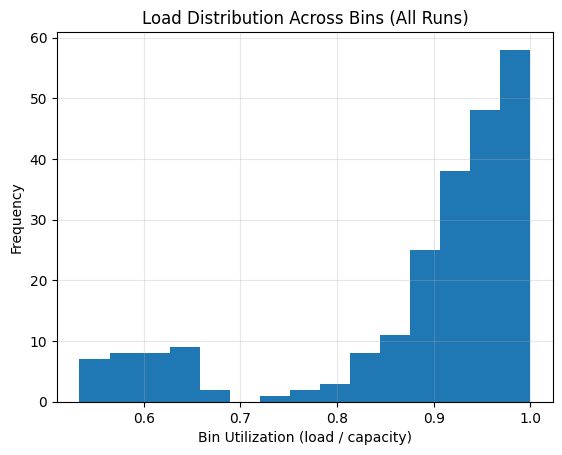

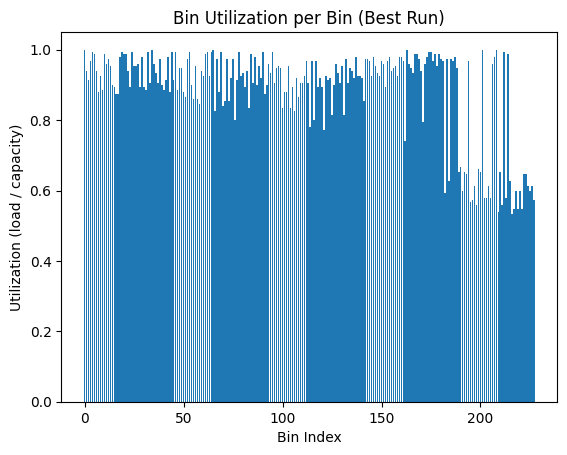

Total runtime for 20 runs: 45.15 seconds


In [22]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #3

Mean number of final bins 228.45
Median number of final bins 228.0
Best number of final bins 228
Worst number of final bins 229
Standard deviation 0.49749371855331


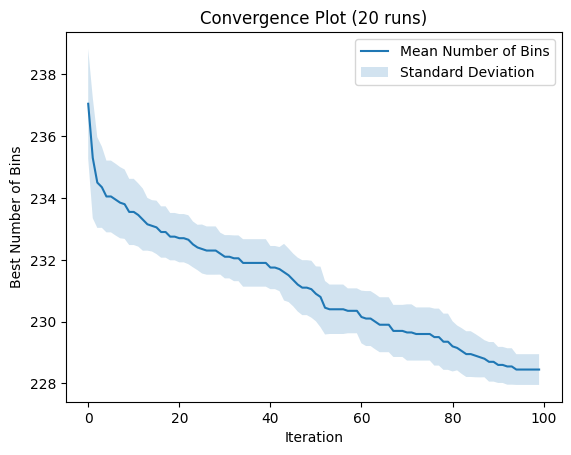

Mean number of unused capacity  4051.5
Median number of unused capacity 3984.0
Best number of unused capacity 3984.0
Worst number of unused capacity 4134.0
Standard deviation of unused capacity 74.6240577829965


Load Distribution for the best solution
The unused capacity for best solution 3984.0


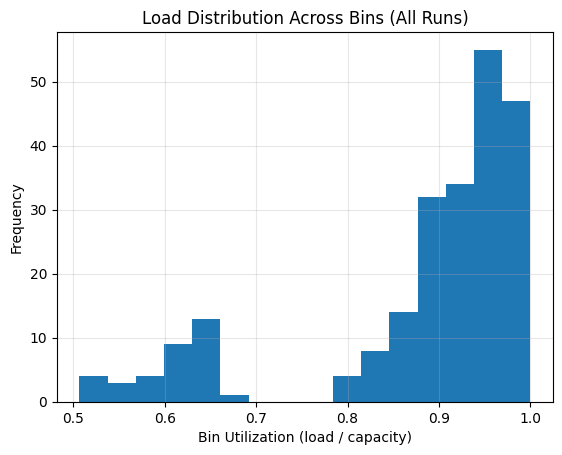

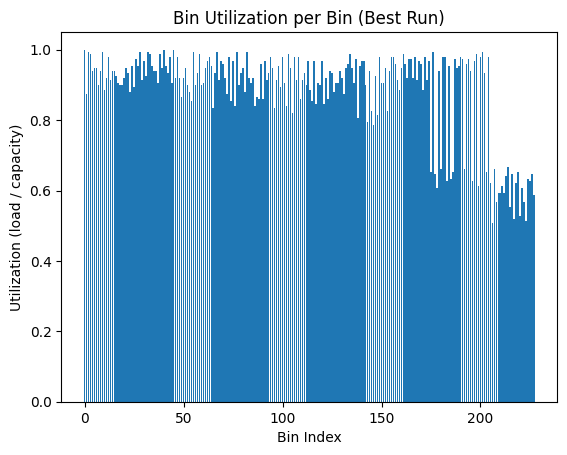

Total runtime for 20 runs: 30.84 seconds


In [23]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #3

Mean number of final bins 221.75
Median number of final bins 222.0
Best number of final bins 219
Worst number of final bins 223
Standard deviation 1.0897247358851685


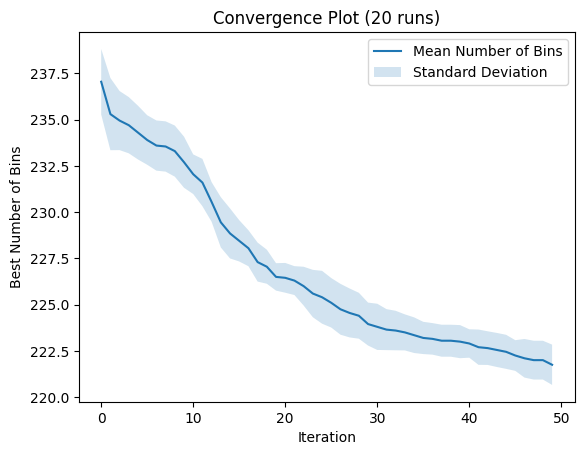

Mean number of unused capacity  3046.5
Median number of unused capacity 3084.0
Best number of unused capacity 2634.0
Worst number of unused capacity 3234.0
Standard deviation of unused capacity 163.45871038277525


Load Distribution for the best solution
The unused capacity for best solution 2634.0


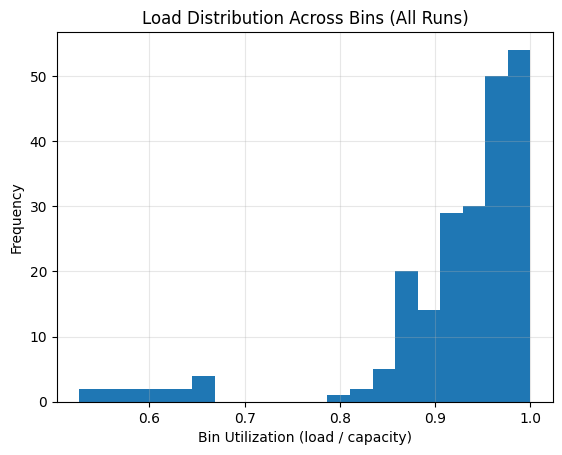

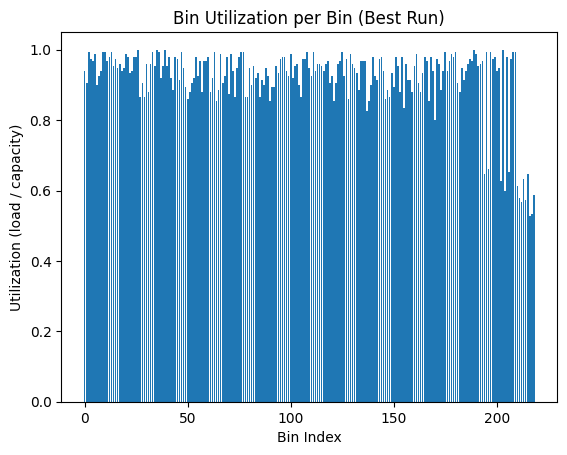

Total runtime for 20 runs: 16.19 seconds


In [24]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #3




 Alpha Value: 0.5
Mean number of final bins 232.0
Median number of final bins 232.0
Best number of final bins 230
Worst number of final bins 233
Standard deviation 0.8944271909999159


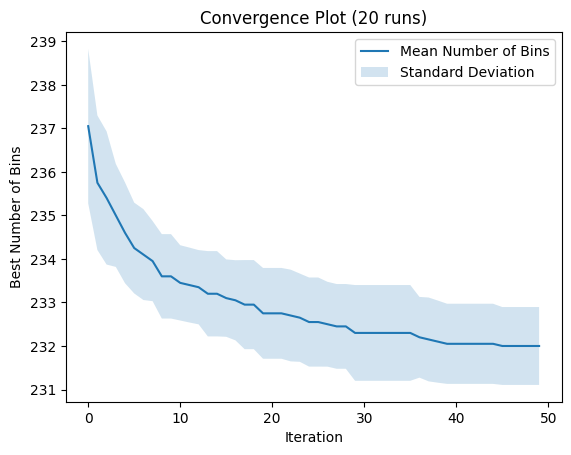

Mean number of unused capacity  4584.0
Median number of unused capacity 4584.0
Best number of unused capacity 4284.0
Worst number of unused capacity 4734.0
Standard deviation of unused capacity 134.16407864998737


Load Distribution for the best solution
The unused capacity for best solution 4284.0


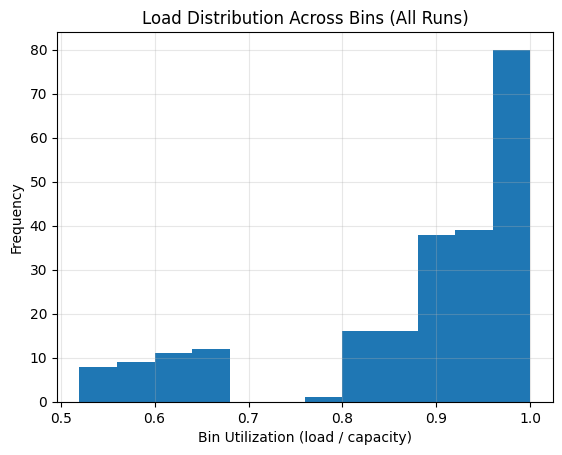

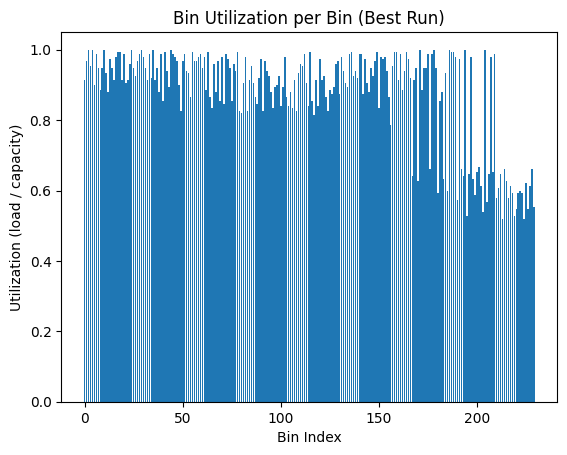

Total runtime for 20 runs: 15.24 seconds



 Alpha Value: 2
Mean number of final bins 224.95
Median number of final bins 225.0
Best number of final bins 223
Worst number of final bins 226
Standard deviation 0.8645808232895291


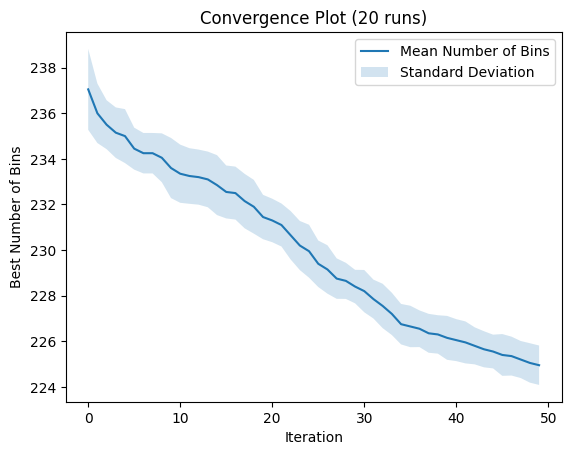

Mean number of unused capacity  3526.5
Median number of unused capacity 3534.0
Best number of unused capacity 3234.0
Worst number of unused capacity 3684.0
Standard deviation of unused capacity 129.68712349342937


Load Distribution for the best solution
The unused capacity for best solution 3234.0


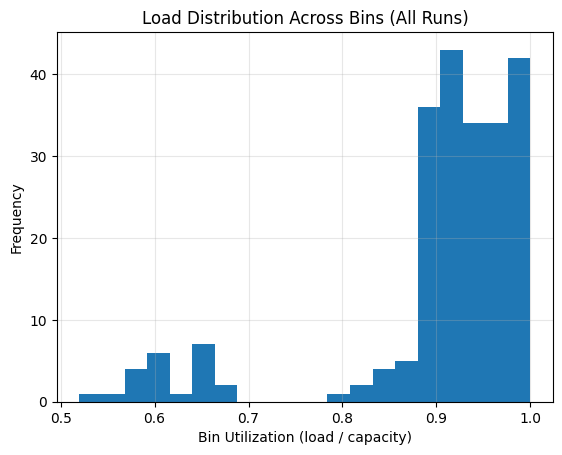

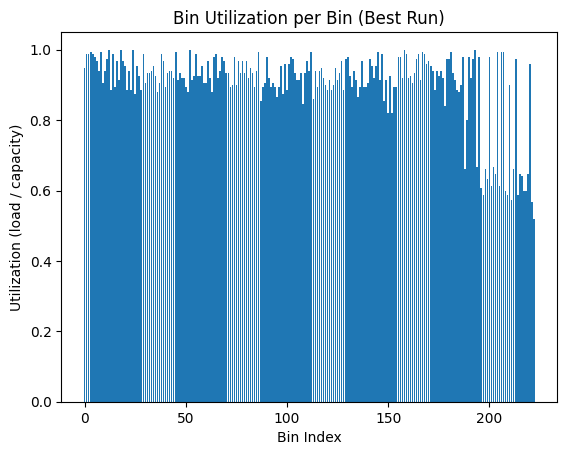

Total runtime for 20 runs: 15.98 seconds


In [25]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #3




Beta value is:  0.5
Mean number of final bins 225.2
Median number of final bins 225.0
Best number of final bins 222
Worst number of final bins 227
Standard deviation 1.077032961426901


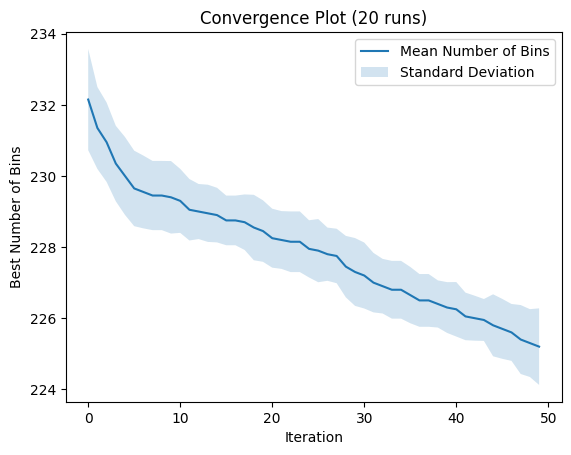

Mean number of unused capacity  3564.0
Median number of unused capacity 3534.0
Best number of unused capacity 3084.0
Worst number of unused capacity 3834.0
Standard deviation of unused capacity 161.55494421403512


Load Distribution for the best solution
The unused capacity for best solution 3084.0


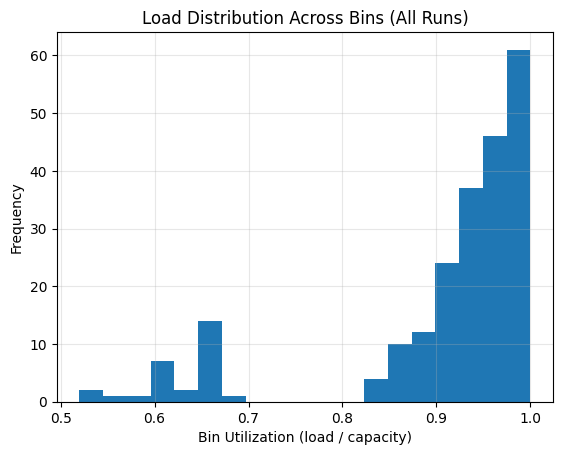

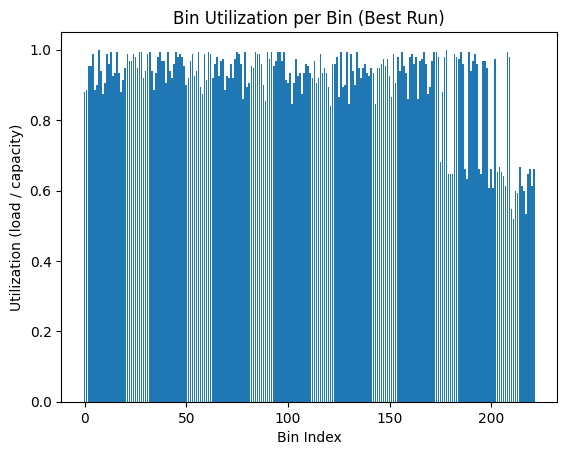

Total runtime for 20 runs: 15.54 seconds



Beta value is:  2
Mean number of final bins 236.5
Median number of final bins 236.0
Best number of final bins 235
Worst number of final bins 238
Standard deviation 0.7416198487095663


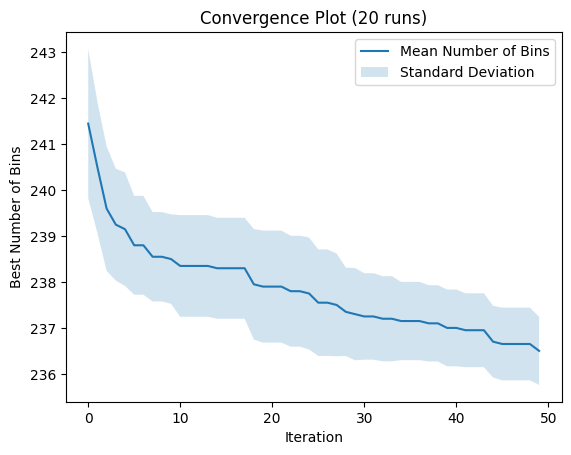

Mean number of unused capacity  5259.0
Median number of unused capacity 5184.0
Best number of unused capacity 5034.0
Worst number of unused capacity 5484.0
Standard deviation of unused capacity 111.24297730643494


Load Distribution for the best solution
The unused capacity for best solution 5034.0


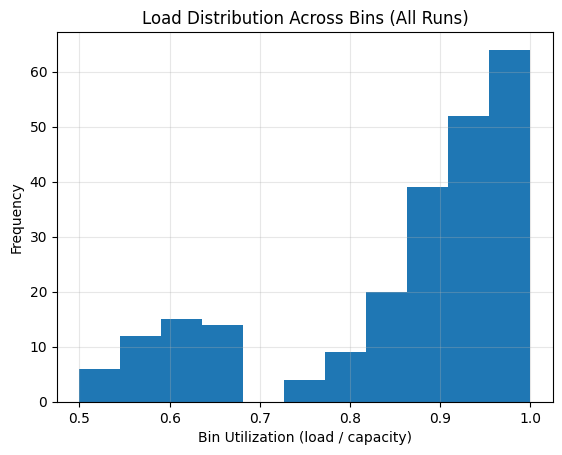

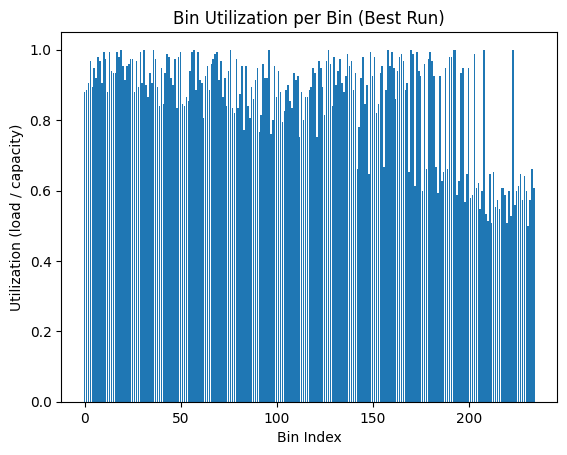

Total runtime for 20 runs: 14.98 seconds


In [26]:

betas = [0.5, 2]
for beta in betas:
    print("\n\n\nBeta value is: ", beta)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = beta, n_runs = 20)


# Problem #4

In [27]:
# Get the data


filename = "Data/1-D Bin Packing /binpack4.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[3]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  150
Number of items:  1000


Mean number of final bins 476.6
Median number of final bins 477.0
Best number of final bins 474
Worst number of final bins 479
Standard deviation 1.6852299546352716


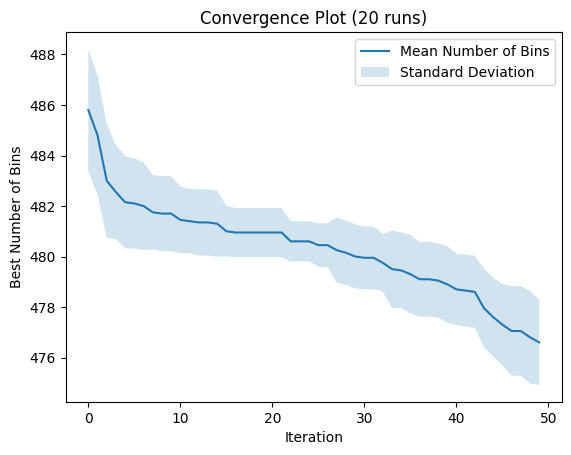

Mean number of unused capacity  9860.0
Median number of unused capacity 9920.0
Best number of unused capacity 9470.0
Worst number of unused capacity 10220.0
Standard deviation of unused capacity 252.78449319529076


Load Distribution for the best solution
The unused capacity for best solution 9470.0


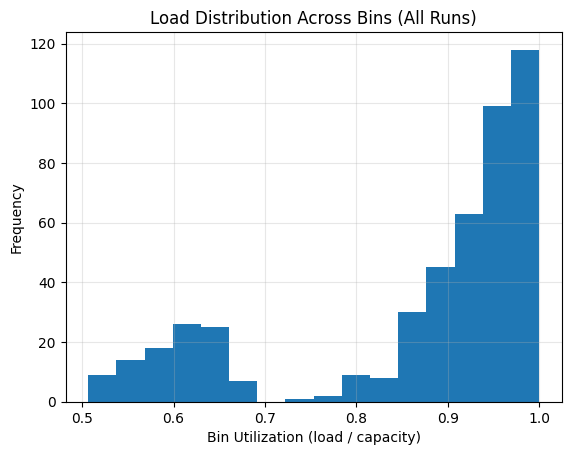

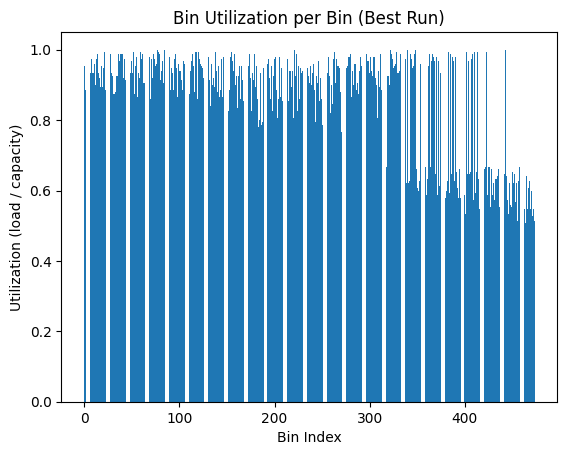

Total runtime for 20 runs: 54.93 seconds


In [28]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #4

Mean number of final bins 475.8
Median number of final bins 476.5
Best number of final bins 469
Worst number of final bins 478
Standard deviation 2.2271057451320084


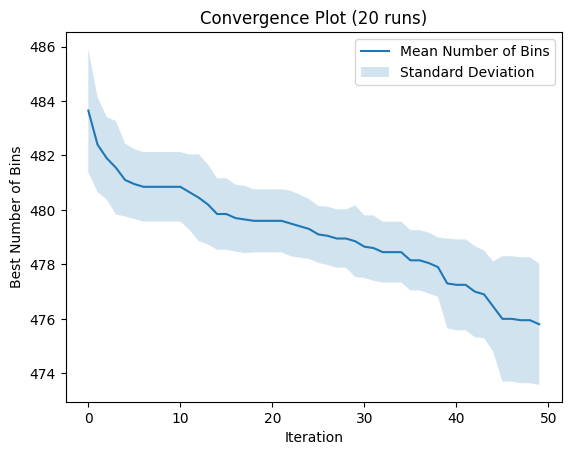

Mean number of unused capacity  9740.0
Median number of unused capacity 9845.0
Best number of unused capacity 8720.0
Worst number of unused capacity 10070.0
Standard deviation of unused capacity 334.0658617698013


Load Distribution for the best solution
The unused capacity for best solution 8720.0


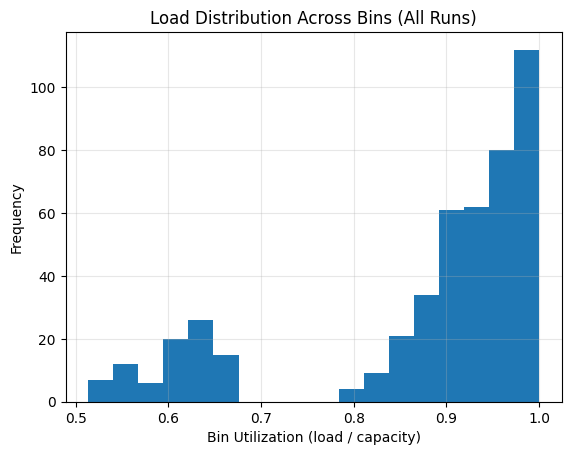

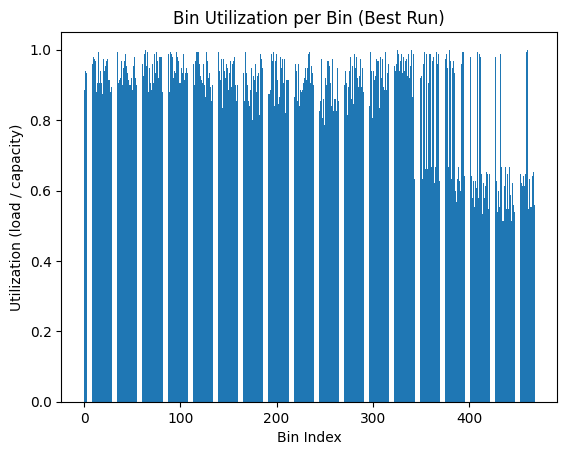

Total runtime for 20 runs: 162.18 seconds


In [29]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #4

Mean number of final bins 471.25
Median number of final bins 471.0
Best number of final bins 469
Worst number of final bins 473
Standard deviation 1.0897247358851685


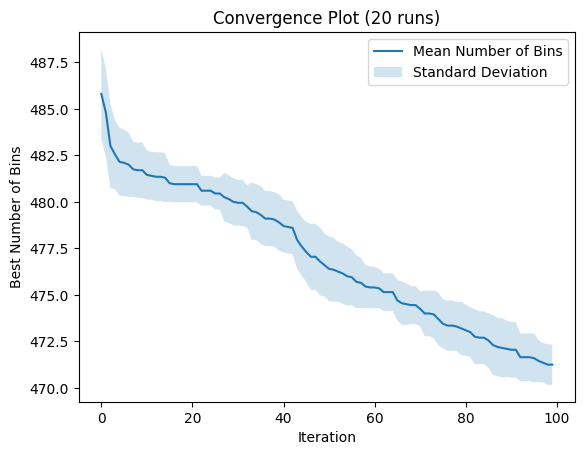

Mean number of unused capacity  9057.5
Median number of unused capacity 9020.0
Best number of unused capacity 8720.0
Worst number of unused capacity 9320.0
Standard deviation of unused capacity 163.45871038277525


Load Distribution for the best solution
The unused capacity for best solution 8720.0


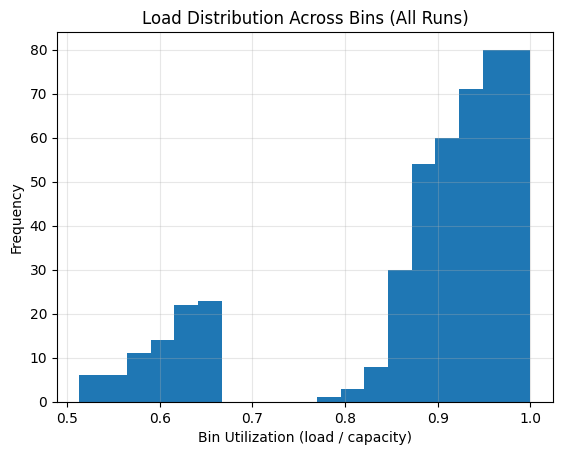

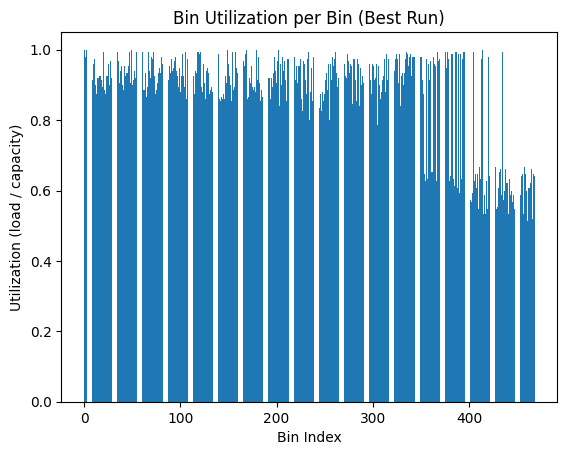

Total runtime for 20 runs: 112.86 seconds


In [30]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #4

Mean number of final bins 457.7
Median number of final bins 457.0
Best number of final bins 456
Worst number of final bins 460
Standard deviation 1.2288205727444508


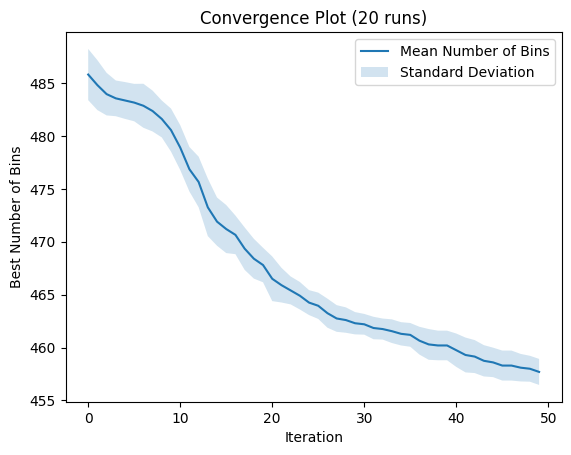

Mean number of unused capacity  7025.0
Median number of unused capacity 6920.0
Best number of unused capacity 6770.0
Worst number of unused capacity 7370.0
Standard deviation of unused capacity 184.32308591166762


Load Distribution for the best solution
The unused capacity for best solution 6770.0


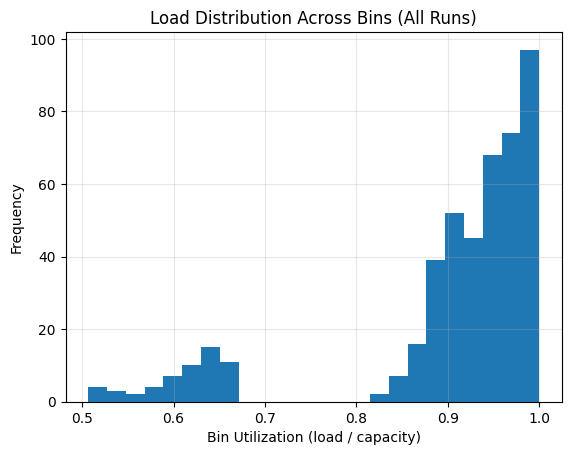

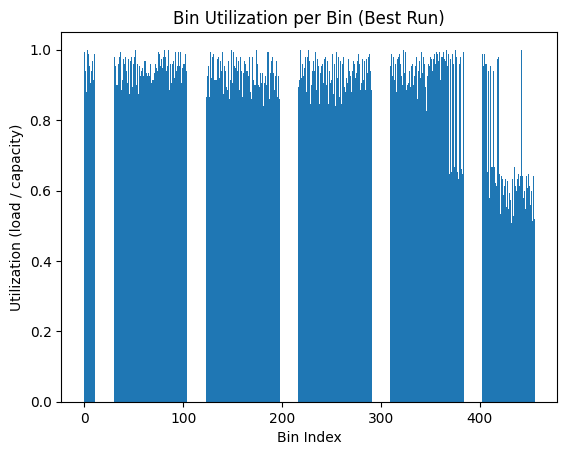

Total runtime for 20 runs: 58.59 seconds


In [31]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #4




 Alpha Value: 0.5
Mean number of final bins 479.85
Median number of final bins 480.0
Best number of final bins 477
Worst number of final bins 481
Standard deviation 1.061838029079765


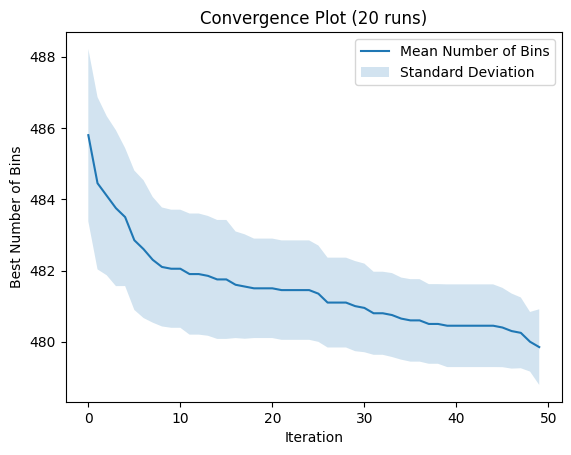

Mean number of unused capacity  10347.5
Median number of unused capacity 10370.0
Best number of unused capacity 9920.0
Worst number of unused capacity 10520.0
Standard deviation of unused capacity 159.27570436196476


Load Distribution for the best solution
The unused capacity for best solution 9920.0


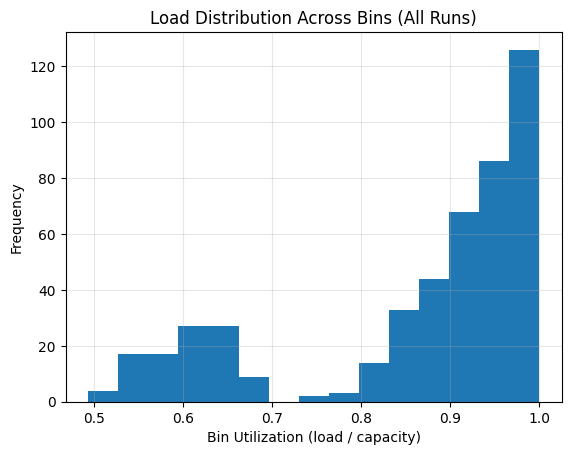

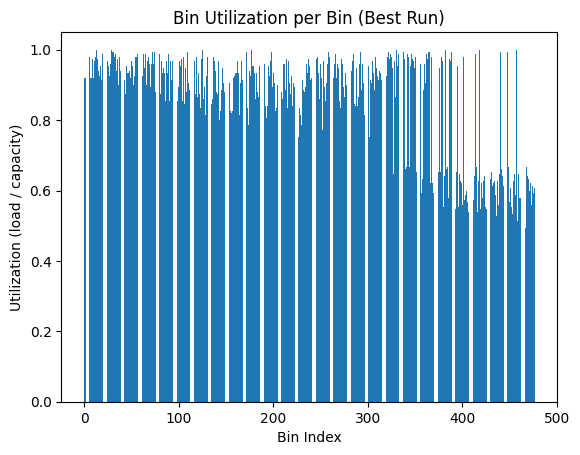

Total runtime for 20 runs: 54.18 seconds



 Alpha Value: 2
Mean number of final bins 464.05
Median number of final bins 464.0
Best number of final bins 461
Worst number of final bins 466
Standard deviation 1.4654350889752843


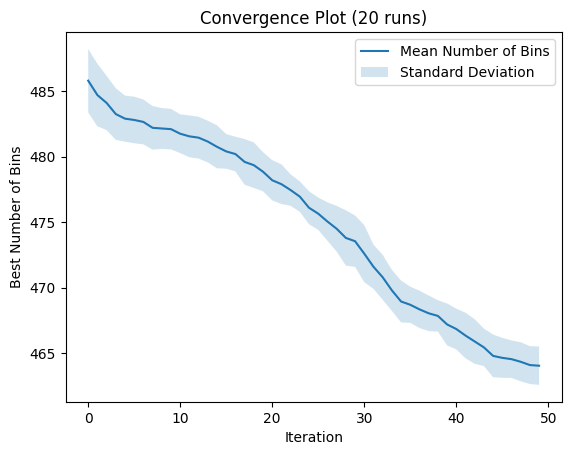

Mean number of unused capacity  7977.5
Median number of unused capacity 7970.0
Best number of unused capacity 7520.0
Worst number of unused capacity 8270.0
Standard deviation of unused capacity 219.81526334629268


Load Distribution for the best solution
The unused capacity for best solution 7520.0


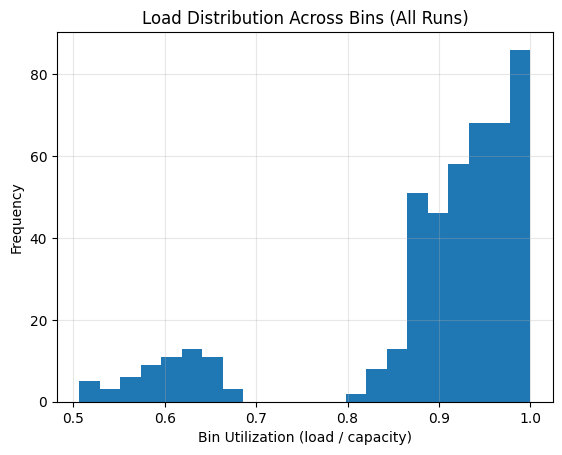

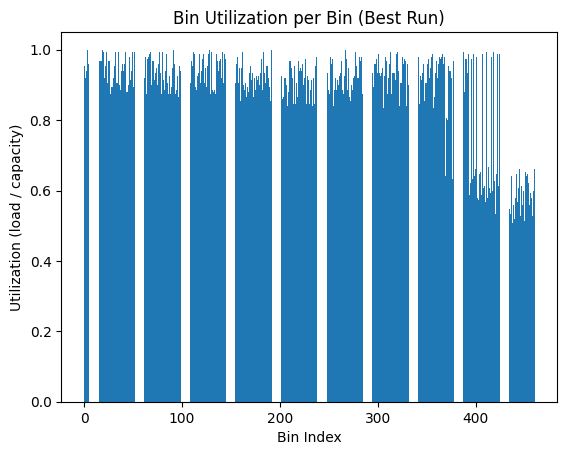

Total runtime for 20 runs: 57.11 seconds


In [32]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #4




Beta value is:  0.5
Mean number of final bins 465.25
Median number of final bins 465.0
Best number of final bins 463
Worst number of final bins 468
Standard deviation 1.299038105676658


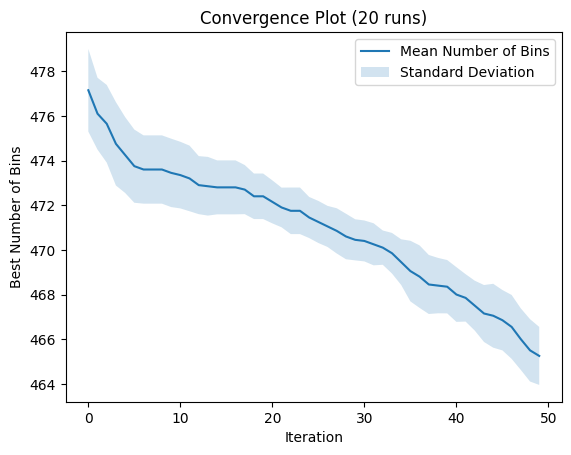

Mean number of unused capacity  8157.5
Median number of unused capacity 8120.0
Best number of unused capacity 7820.0
Worst number of unused capacity 8570.0
Standard deviation of unused capacity 194.8557158514987


Load Distribution for the best solution
The unused capacity for best solution 7820.0


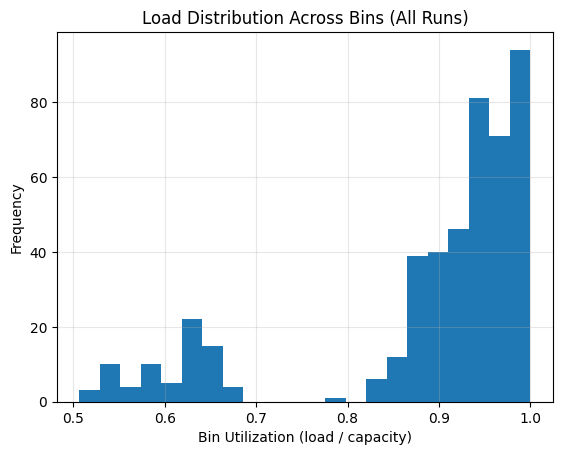

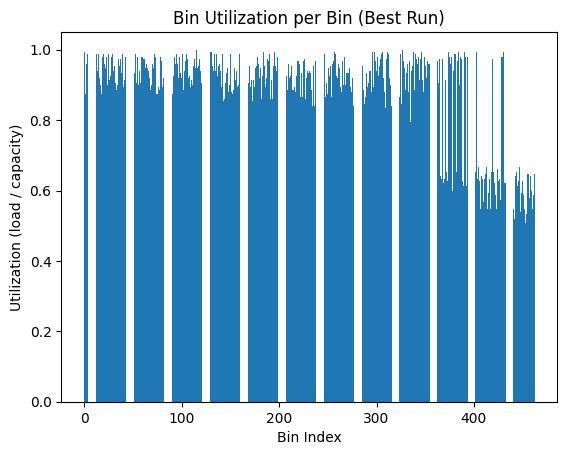

Total runtime for 20 runs: 56.25 seconds



Beta value is:  2
Mean number of final bins 488.4
Median number of final bins 489.0
Best number of final bins 484
Worst number of final bins 490
Standard deviation 1.5937377450509227


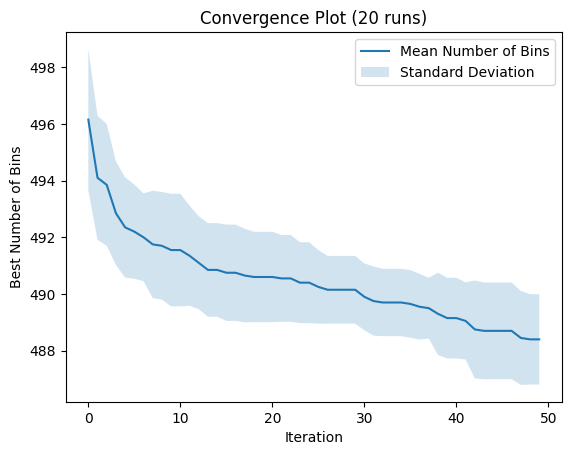

Mean number of unused capacity  11630.0
Median number of unused capacity 11720.0
Best number of unused capacity 10970.0
Worst number of unused capacity 11870.0
Standard deviation of unused capacity 239.0606617576384


Load Distribution for the best solution
The unused capacity for best solution 10970.0


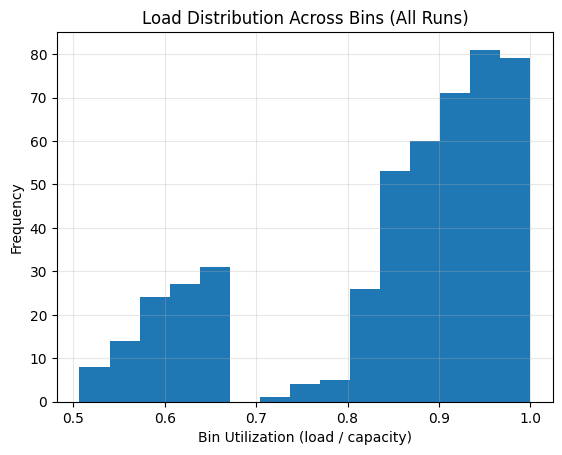

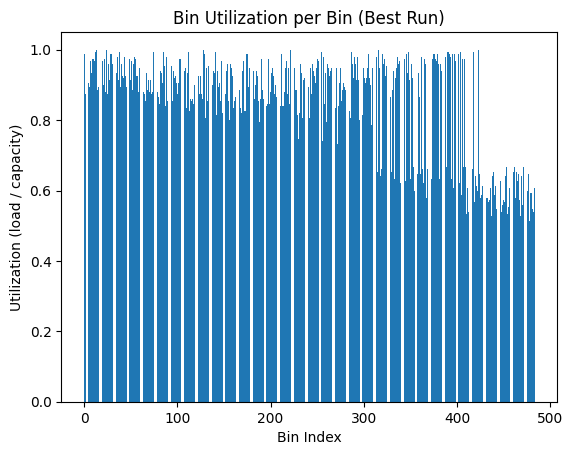

Total runtime for 20 runs: 52.31 seconds


In [33]:

betas = [0.5, 2]
for beta in betas:
    print("\n\n\nBeta value is: ", beta)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = beta, n_runs = 20)


# Problem #5

In [34]:
# Get the data


filename = "Data/1-D Bin Packing /binpack5.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[4]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  100
Number of items:  60


Mean number of final bins 22.0
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 22
Standard deviation 0.0


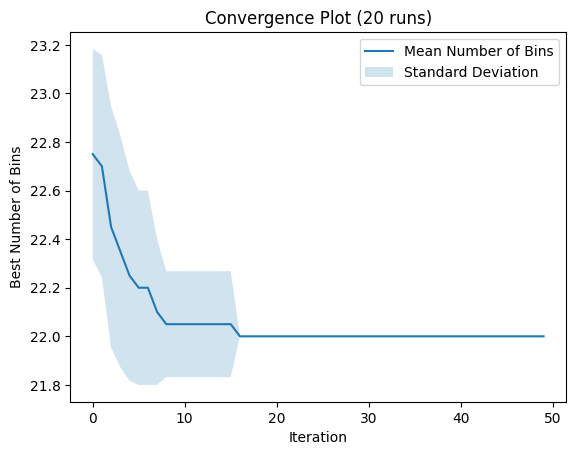

Mean number of unused capacity  200.0
Median number of unused capacity 200.00000000000003
Best number of unused capacity 199.99999999999997
Worst number of unused capacity 200.00000000000006
Standard deviation of unused capacity 3.595093471822542e-14


Load Distribution for the best solution
The unused capacity for best solution 200.00000000000003


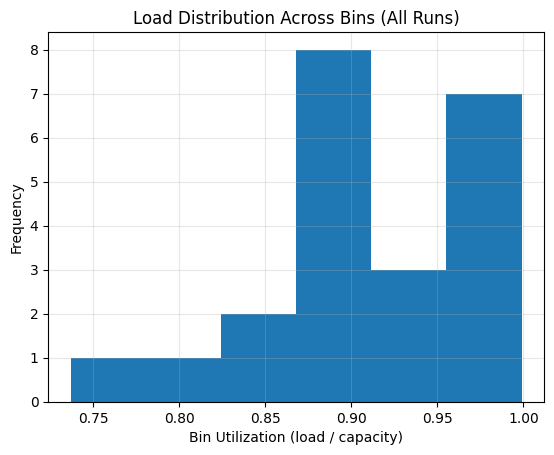

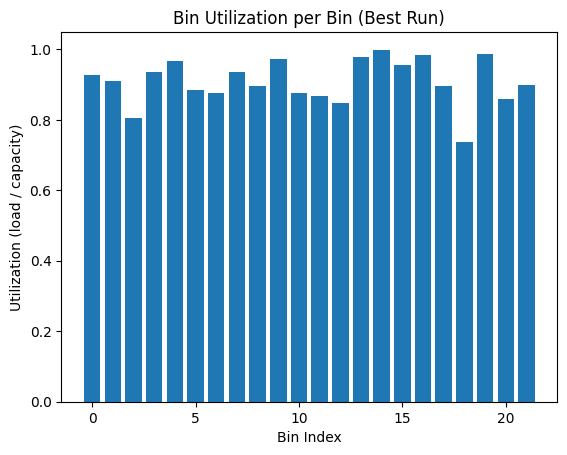

Total runtime for 20 runs: 0.76 seconds


In [35]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #5

Mean number of final bins 22.0
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 22
Standard deviation 0.0


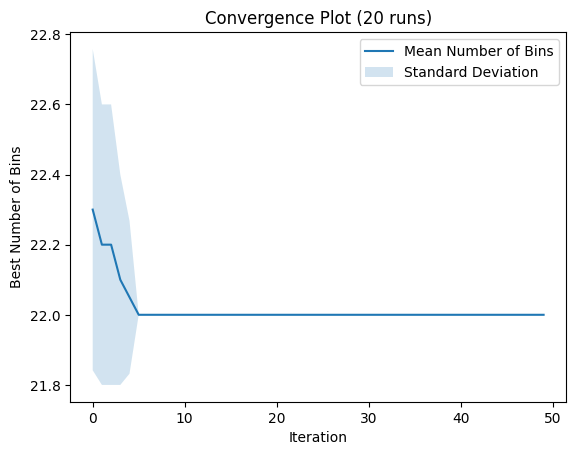

Mean number of unused capacity  200.0
Median number of unused capacity 200.0
Best number of unused capacity 199.99999999999994
Worst number of unused capacity 200.00000000000006
Standard deviation of unused capacity 3.240573463185507e-14


Load Distribution for the best solution
The unused capacity for best solution 200.00000000000003


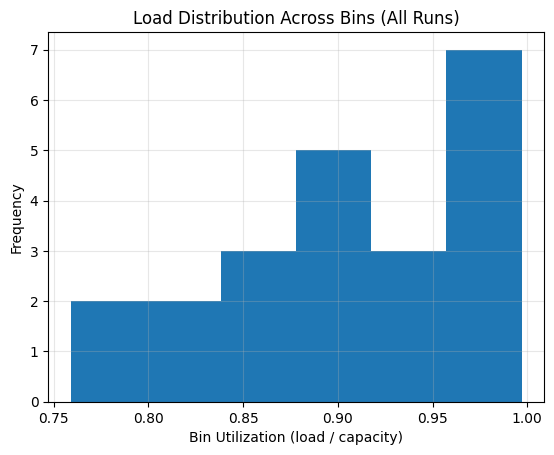

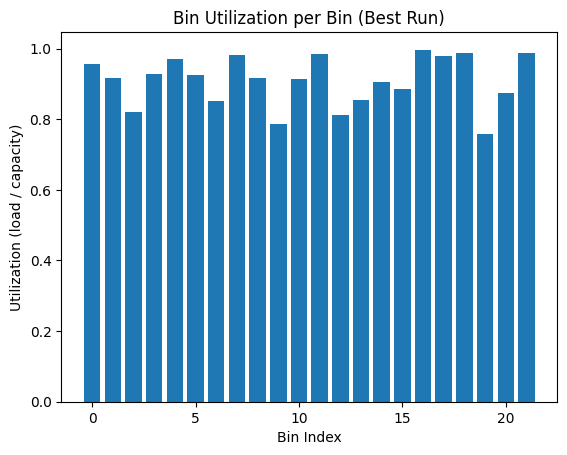

Total runtime for 20 runs: 1.75 seconds


In [36]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #5

Mean number of final bins 22.0
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 22
Standard deviation 0.0


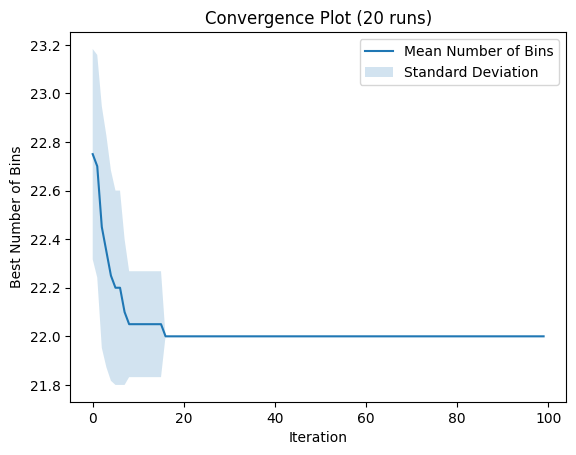

Mean number of unused capacity  200.0
Median number of unused capacity 200.00000000000003
Best number of unused capacity 199.99999999999997
Worst number of unused capacity 200.00000000000006
Standard deviation of unused capacity 3.595093471822542e-14


Load Distribution for the best solution
The unused capacity for best solution 200.00000000000003


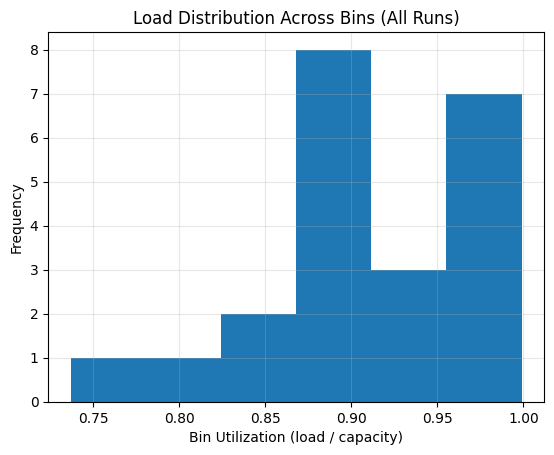

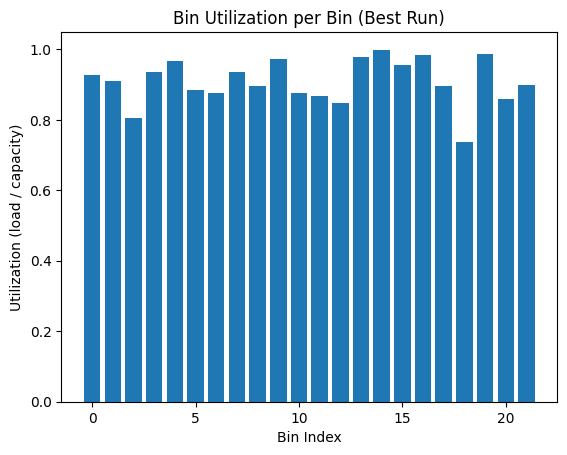

Total runtime for 20 runs: 1.28 seconds


In [37]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #5

Mean number of final bins 22.05
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 23
Standard deviation 0.21794494717703367


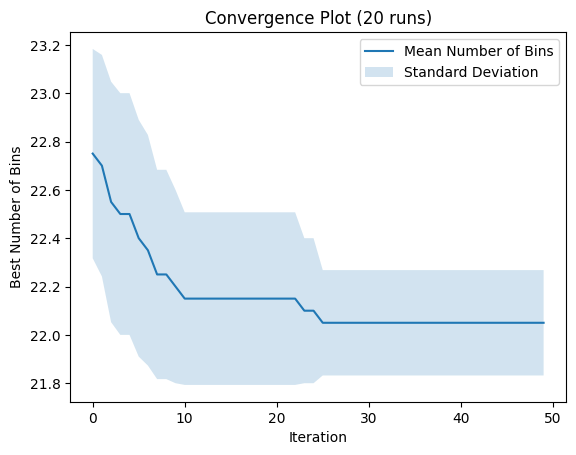

Mean number of unused capacity  205.0
Median number of unused capacity 200.0
Best number of unused capacity 199.99999999999994
Worst number of unused capacity 300.0
Standard deviation of unused capacity 21.794494717703365


Load Distribution for the best solution
The unused capacity for best solution 200.00000000000003


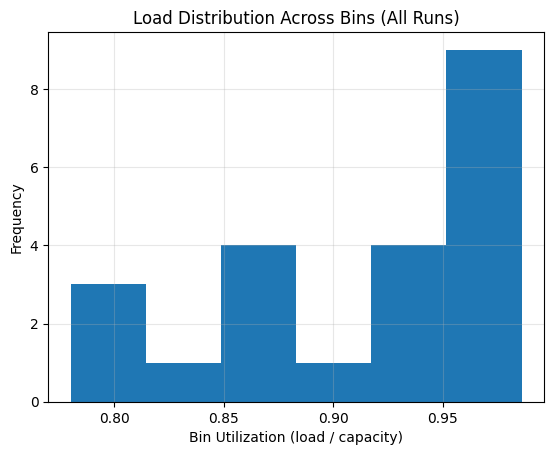

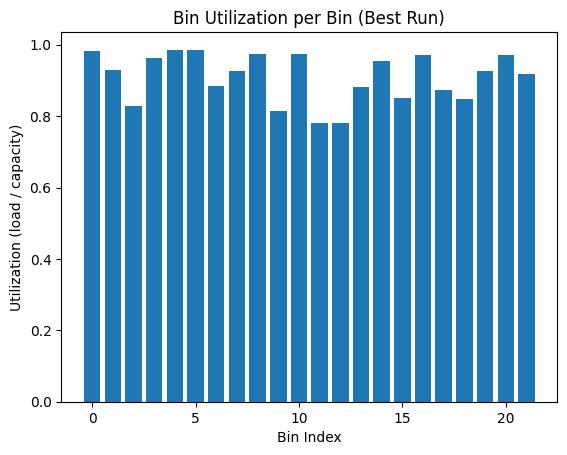

Total runtime for 20 runs: 0.76 seconds


In [38]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #5




 Alpha Value: 0.5
Mean number of final bins 22.0
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 22
Standard deviation 0.0


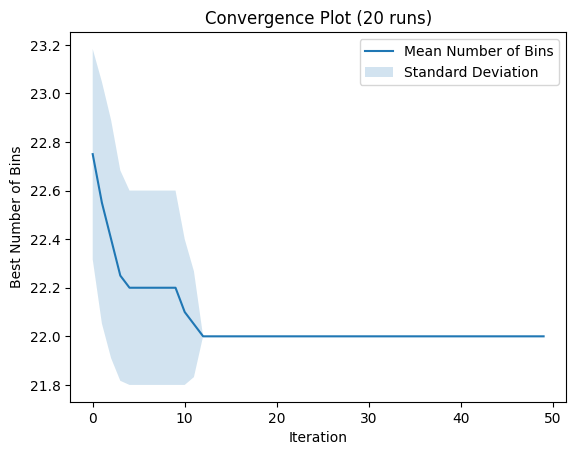

Mean number of unused capacity  200.0
Median number of unused capacity 200.0
Best number of unused capacity 199.99999999999994
Worst number of unused capacity 200.00000000000009
Standard deviation of unused capacity 3.865770426254881e-14


Load Distribution for the best solution
The unused capacity for best solution 200.0


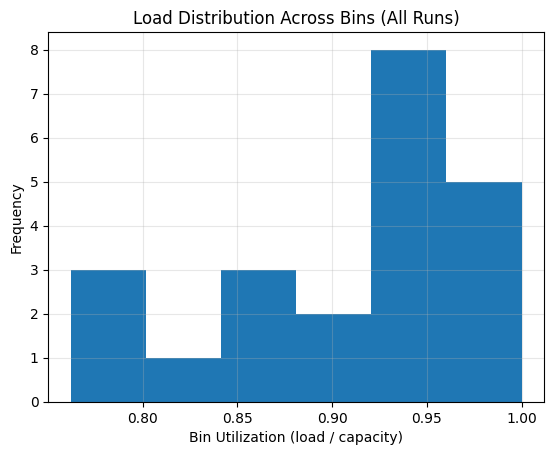

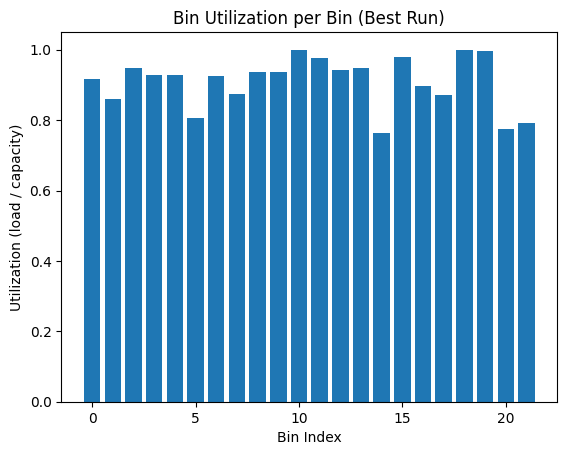

Total runtime for 20 runs: 0.76 seconds



 Alpha Value: 2
Mean number of final bins 22.05
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 23
Standard deviation 0.21794494717703367


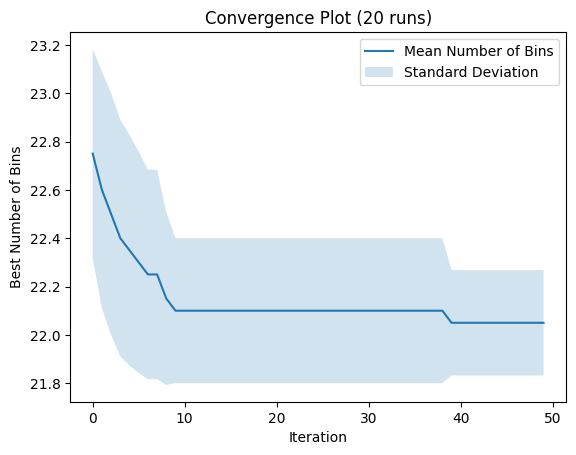

Mean number of unused capacity  205.0
Median number of unused capacity 200.0
Best number of unused capacity 199.99999999999994
Worst number of unused capacity 300.0
Standard deviation of unused capacity 21.794494717703365


Load Distribution for the best solution
The unused capacity for best solution 200.0


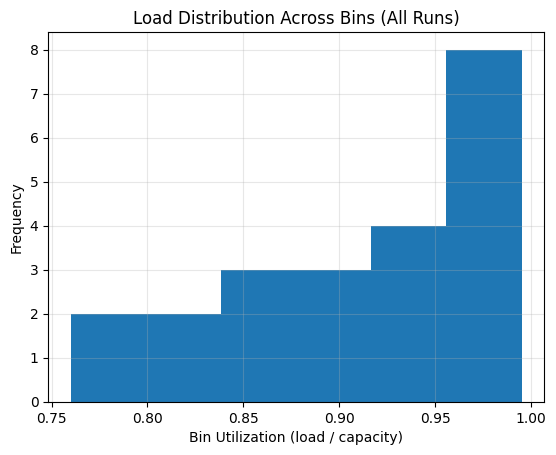

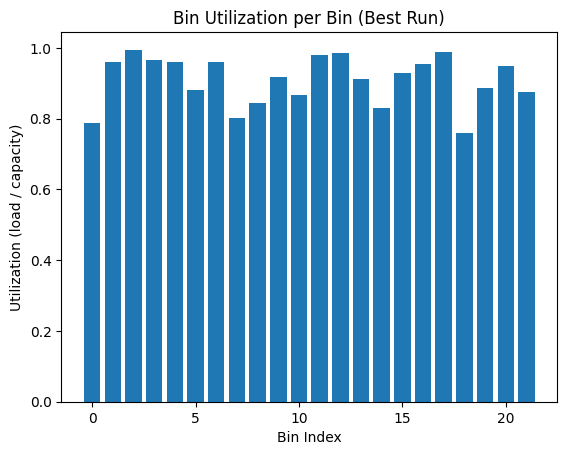

Total runtime for 20 runs: 0.76 seconds


In [39]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

## Modify Beta #5




Beta value is:  0.5
Mean number of final bins 21.95
Median number of final bins 22.0
Best number of final bins 21
Worst number of final bins 22
Standard deviation 0.21794494717703367


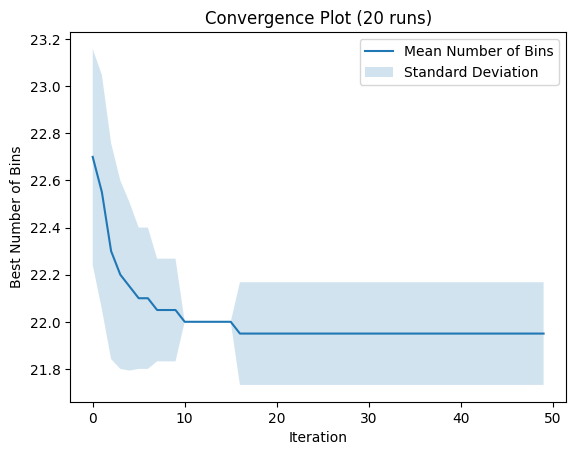

Mean number of unused capacity  195.0
Median number of unused capacity 200.0
Best number of unused capacity 100.0
Worst number of unused capacity 200.0000000000001
Standard deviation of unused capacity 21.79449471770337


Load Distribution for the best solution
The unused capacity for best solution 100.0


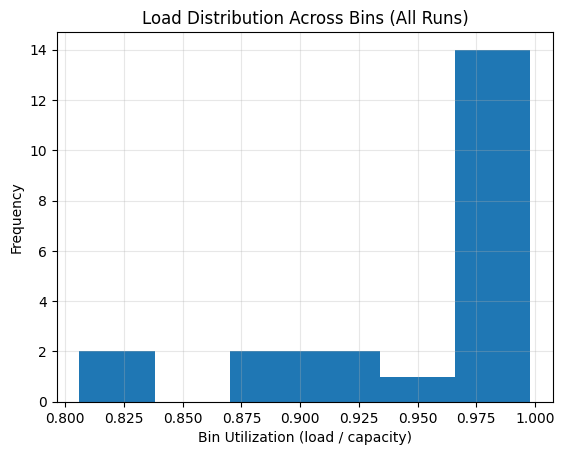

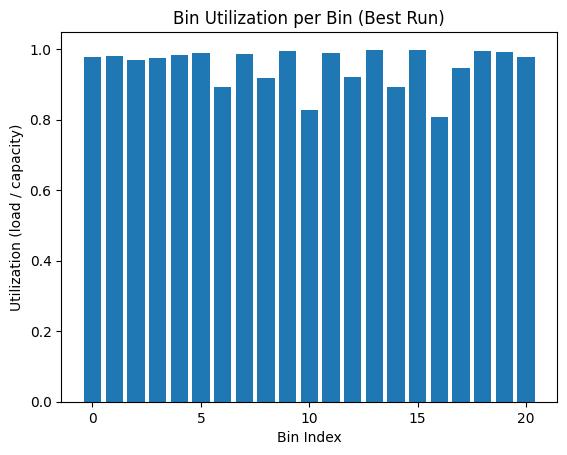

Total runtime for 20 runs: 0.78 seconds



Beta value is:  2
Mean number of final bins 22.05
Median number of final bins 22.0
Best number of final bins 22
Worst number of final bins 23
Standard deviation 0.21794494717703367


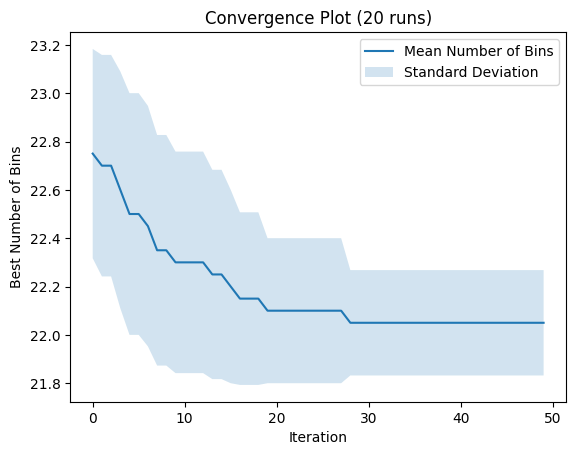

Mean number of unused capacity  205.0
Median number of unused capacity 200.0
Best number of unused capacity 199.99999999999997
Worst number of unused capacity 300.0
Standard deviation of unused capacity 21.794494717703365


Load Distribution for the best solution
The unused capacity for best solution 199.99999999999997


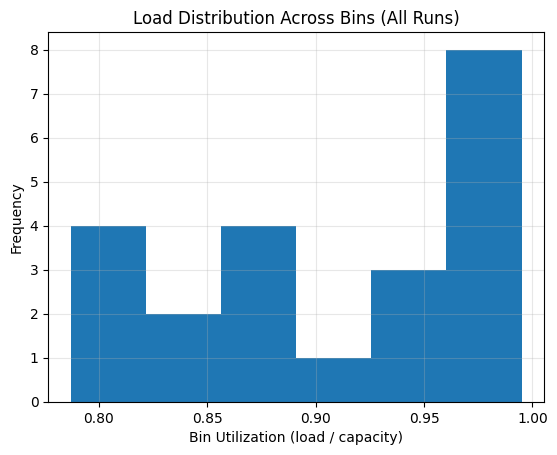

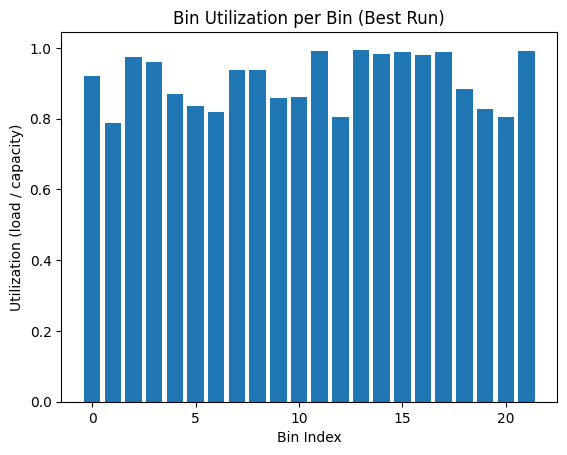

Total runtime for 20 runs: 0.75 seconds


In [40]:
betas = [0.5, 2]
for beta in betas:
    print("\n\n\nBeta value is: ", beta)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = beta, n_runs = 20)


# Problem #6

In [41]:
# Get the data


filename = "Data/1-D Bin Packing /binpack6.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[5]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  100
Number of items:  120


Mean number of final bins 44.3
Median number of final bins 44.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.45825756949558394


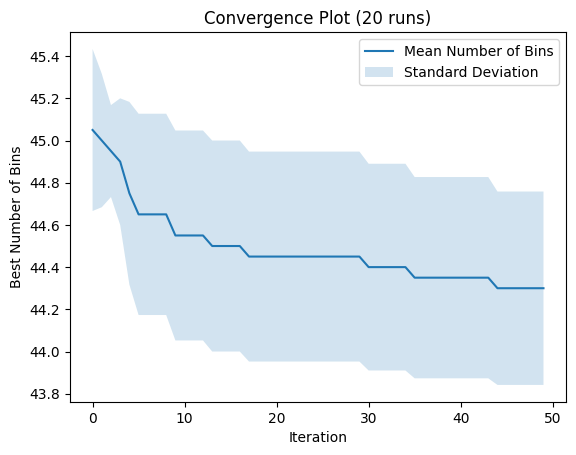

Mean number of unused capacity  430.0
Median number of unused capacity 400.00000000000006
Best number of unused capacity 399.9999999999999
Worst number of unused capacity 500.0000000000001
Standard deviation of unused capacity 45.8257569495584


Load Distribution for the best solution
The unused capacity for best solution 400.0000000000001


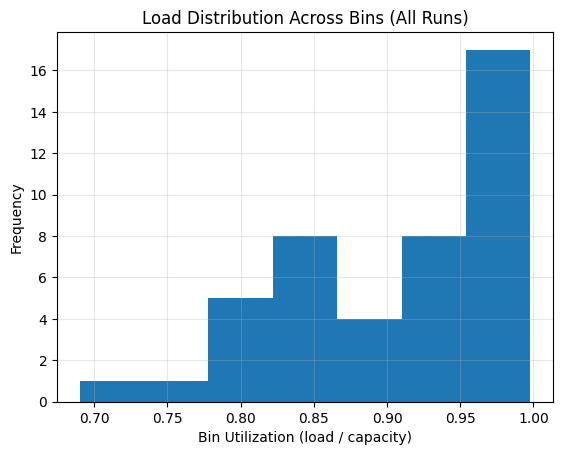

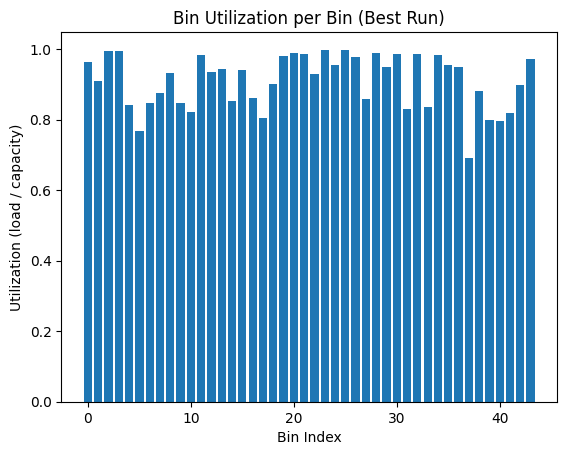

Total runtime for 20 runs: 1.88 seconds


In [42]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #6

Mean number of final bins 44.1
Median number of final bins 44.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.3


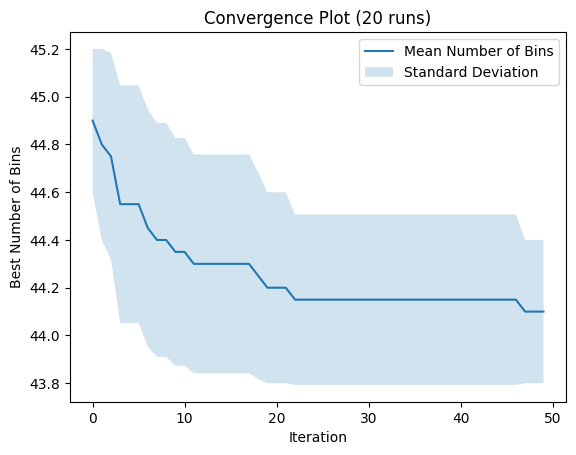

Mean number of unused capacity  410.0
Median number of unused capacity 400.0
Best number of unused capacity 399.99999999999994
Worst number of unused capacity 500.0000000000001
Standard deviation of unused capacity 30.000000000000018


Load Distribution for the best solution
The unused capacity for best solution 400.00000000000006


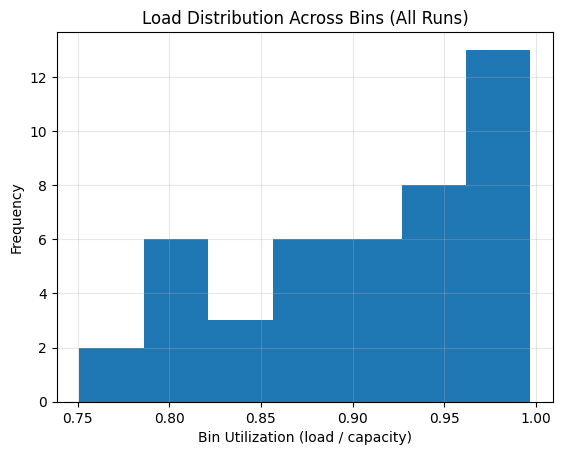

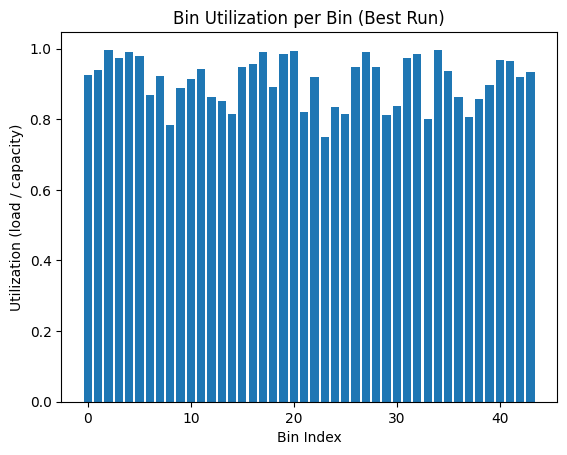

Total runtime for 20 runs: 5.06 seconds


In [43]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #6

Mean number of final bins 44.2
Median number of final bins 44.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.39999999999999997


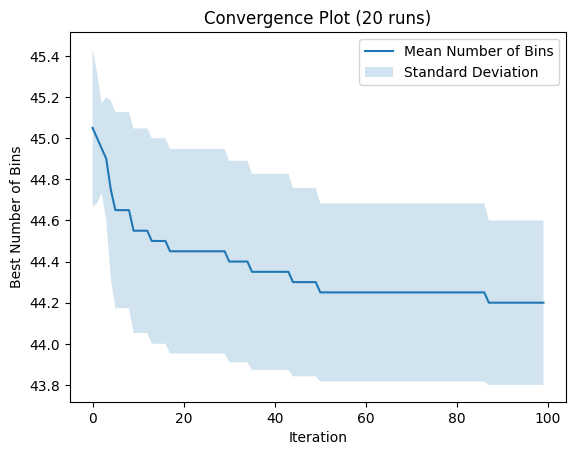

Mean number of unused capacity  420.0
Median number of unused capacity 400.00000000000006
Best number of unused capacity 399.9999999999999
Worst number of unused capacity 500.00000000000006
Standard deviation of unused capacity 39.99999999999999


Load Distribution for the best solution
The unused capacity for best solution 400.0000000000001


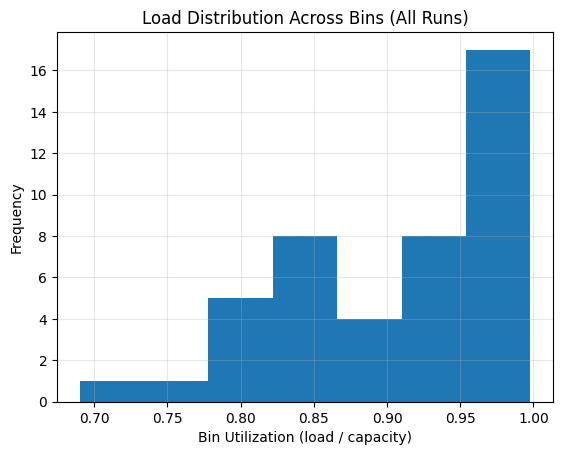

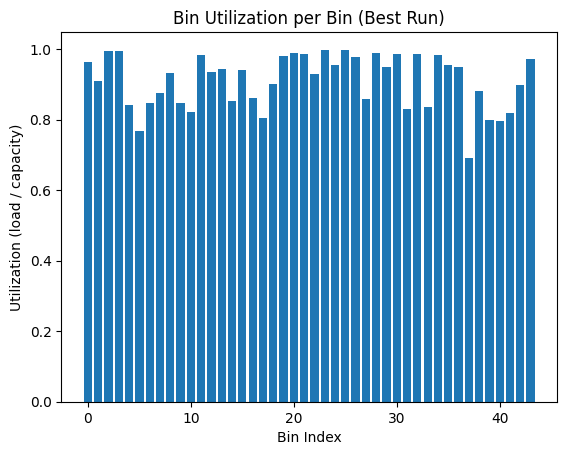

Total runtime for 20 runs: 3.52 seconds


In [44]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #6

Mean number of final bins 44.75
Median number of final bins 45.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.4330127018922193


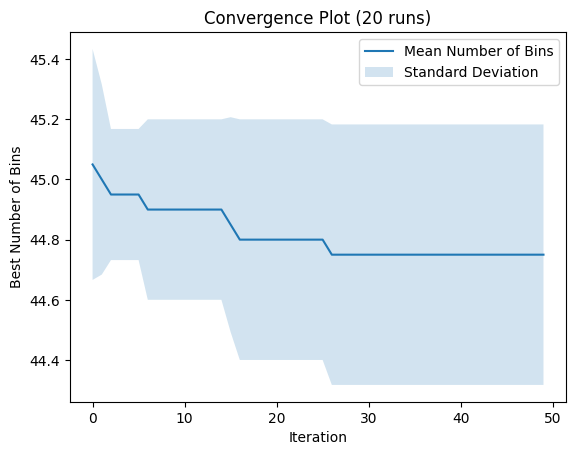

Mean number of unused capacity  475.0
Median number of unused capacity 500.0
Best number of unused capacity 399.99999999999994
Worst number of unused capacity 500.0000000000001
Standard deviation of unused capacity 43.301270189221924


Load Distribution for the best solution
The unused capacity for best solution 400.00000000000006


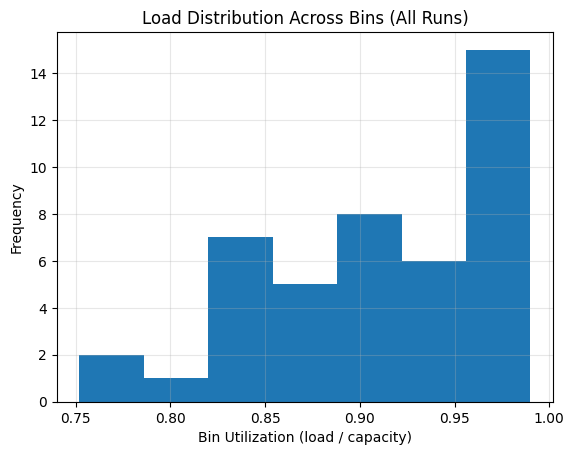

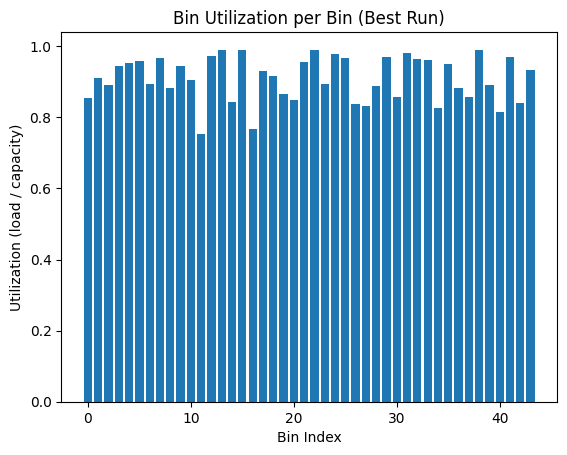

Total runtime for 20 runs: 1.89 seconds


In [45]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #6




 Alpha Value: 0.5
Mean number of final bins 44.3
Median number of final bins 44.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.45825756949558394


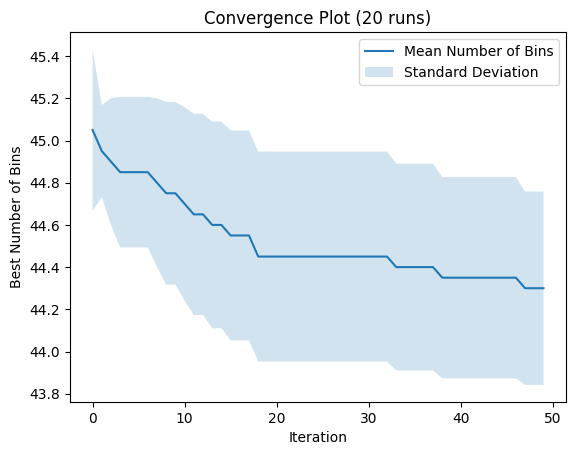

Mean number of unused capacity  430.0
Median number of unused capacity 400.00000000000006
Best number of unused capacity 399.9999999999999
Worst number of unused capacity 500.00000000000006
Standard deviation of unused capacity 45.82575694955841


Load Distribution for the best solution
The unused capacity for best solution 400.00000000000006


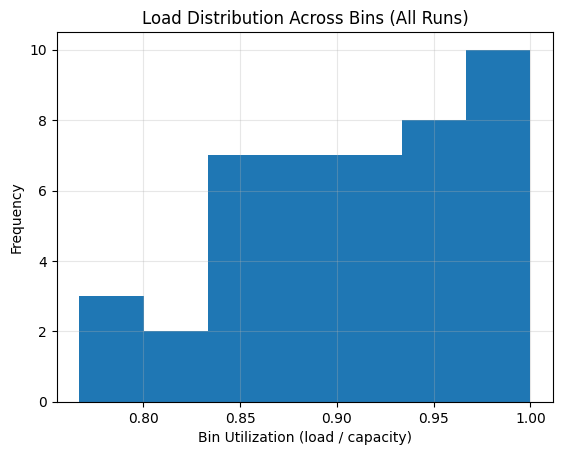

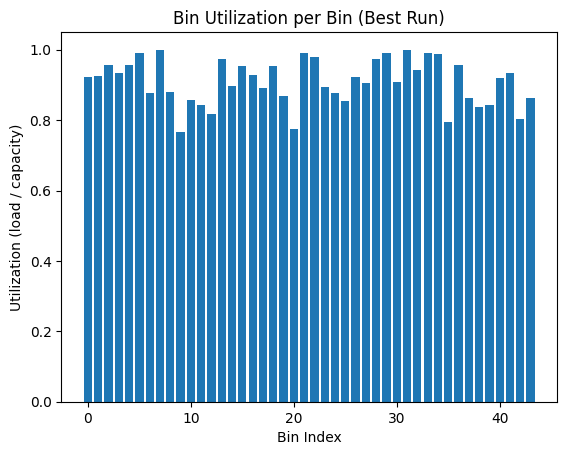

Total runtime for 20 runs: 1.90 seconds



 Alpha Value: 2
Mean number of final bins 44.65
Median number of final bins 45.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.4769696007084729


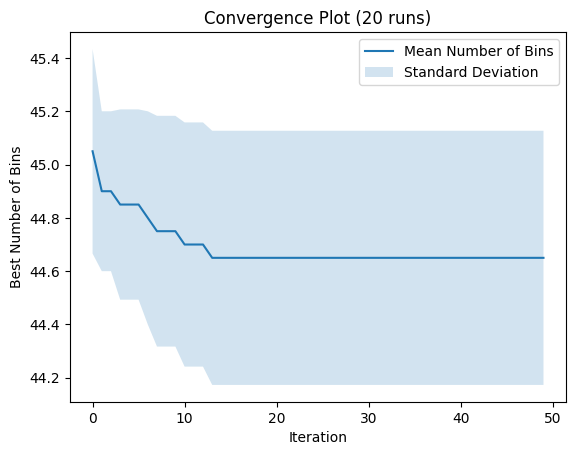

Mean number of unused capacity  465.0
Median number of unused capacity 500.0
Best number of unused capacity 400.0
Worst number of unused capacity 500.0000000000001
Standard deviation of unused capacity 47.696960070847275


Load Distribution for the best solution
The unused capacity for best solution 400.0


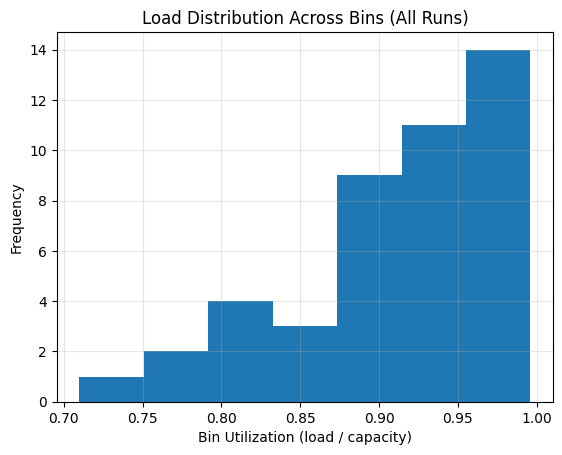

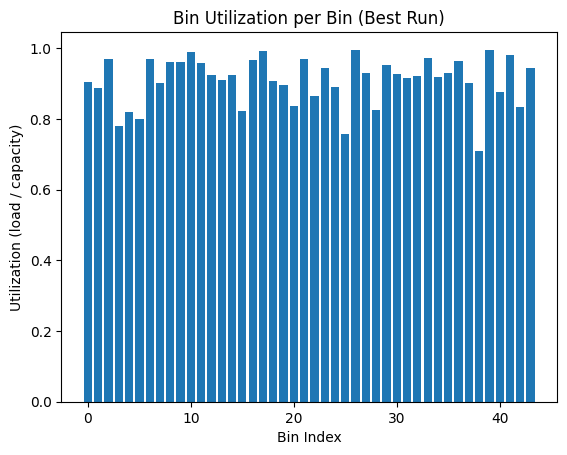

Total runtime for 20 runs: 1.95 seconds


In [46]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #6




Beta value is:  0.5
Mean number of final bins 44.05
Median number of final bins 44.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.21794494717703367


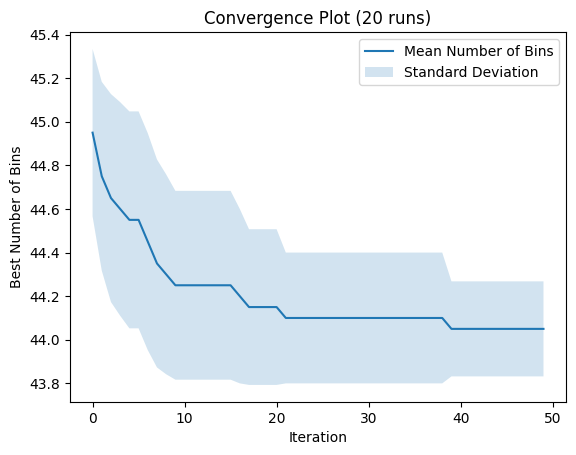

Mean number of unused capacity  405.0000000000001
Median number of unused capacity 400.00000000000006
Best number of unused capacity 400.0
Worst number of unused capacity 500.0
Standard deviation of unused capacity 21.794494717703355


Load Distribution for the best solution
The unused capacity for best solution 400.00000000000006


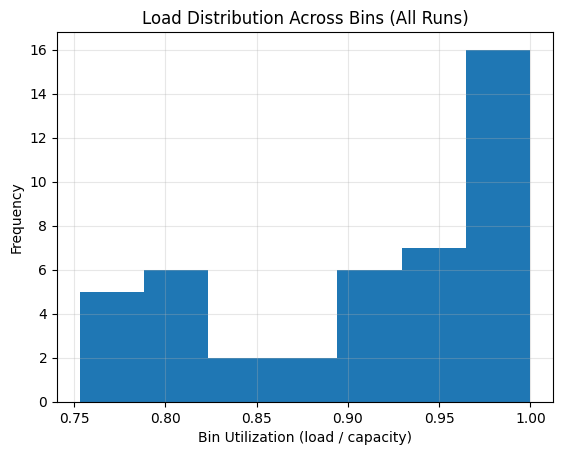

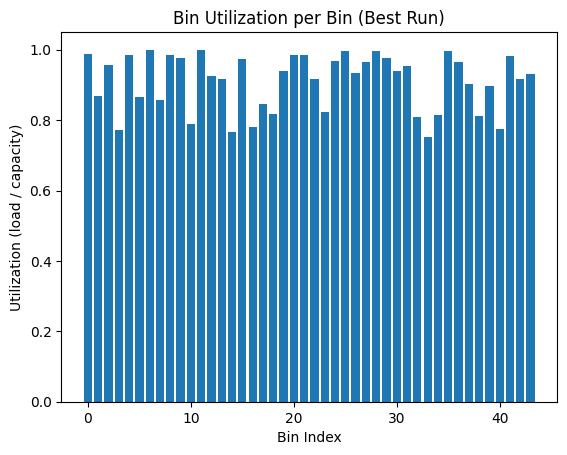

Total runtime for 20 runs: 1.91 seconds



Beta value is:  2
Mean number of final bins 44.9
Median number of final bins 45.0
Best number of final bins 44
Worst number of final bins 45
Standard deviation 0.3


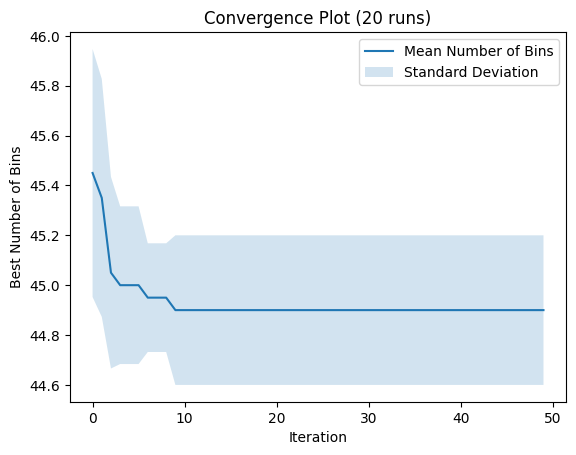

Mean number of unused capacity  490.0
Median number of unused capacity 500.0
Best number of unused capacity 399.9999999999999
Worst number of unused capacity 500.0000000000001
Standard deviation of unused capacity 30.00000000000001


Load Distribution for the best solution
The unused capacity for best solution 399.9999999999999


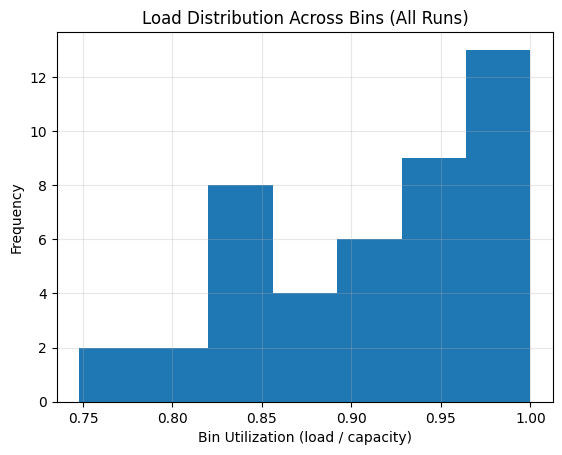

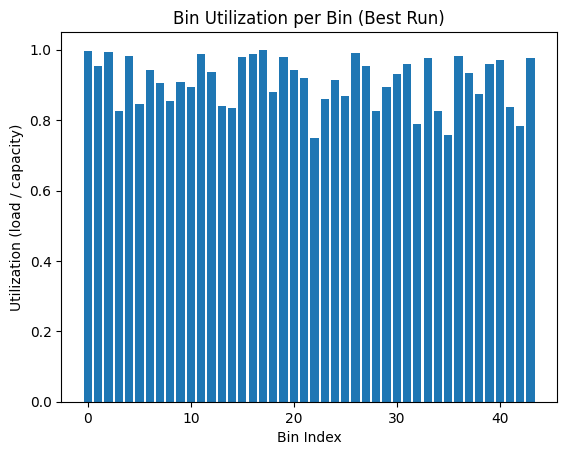

Total runtime for 20 runs: 1.88 seconds


In [47]:
betas = [0.5, 2]
for beta in betas:
    print("\n\n\nBeta value is: ", beta)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = beta, n_runs = 20)


# Problem #7

In [48]:
# Get the data


filename = "Data/1-D Bin Packing /binpack7.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[6]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  100
Number of items:  249


Mean number of final bins 92.7
Median number of final bins 93.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.45825756949558394


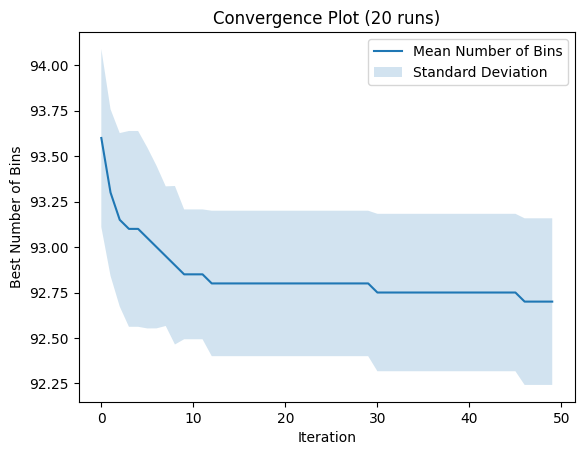

Mean number of unused capacity  970.0
Median number of unused capacity 1000.0
Best number of unused capacity 899.9999999999999
Worst number of unused capacity 1000.0000000000002
Standard deviation of unused capacity 45.8257569495584


Load Distribution for the best solution
The unused capacity for best solution 899.9999999999999


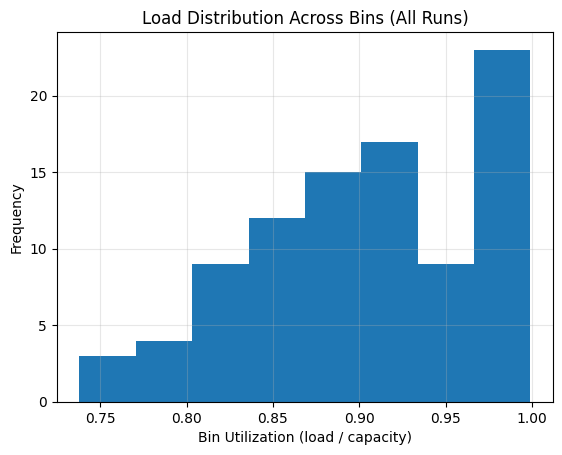

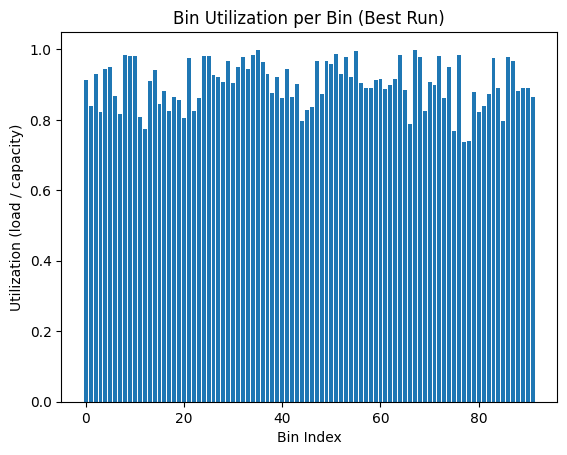

Total runtime for 20 runs: 6.23 seconds


In [49]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #7

Mean number of final bins 92.3
Median number of final bins 92.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.45825756949558394


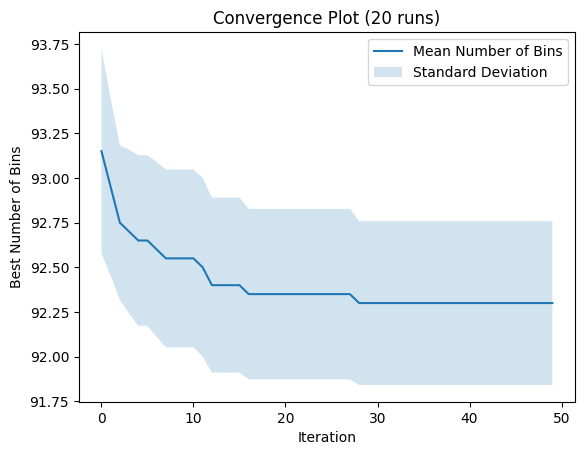

Mean number of unused capacity  930.0
Median number of unused capacity 900.0
Best number of unused capacity 899.9999999999999
Worst number of unused capacity 1000.0000000000002
Standard deviation of unused capacity 45.82575694955839


Load Distribution for the best solution
The unused capacity for best solution 900.0


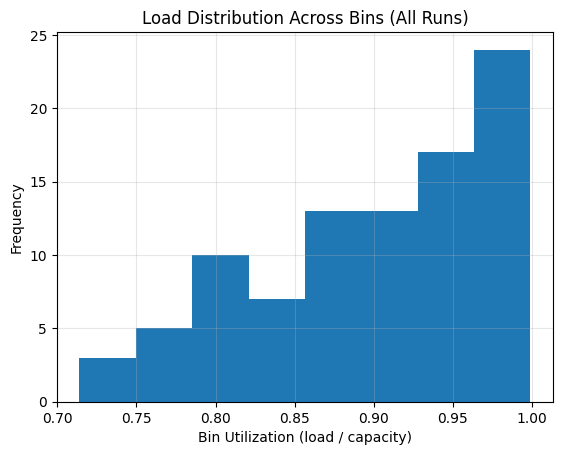

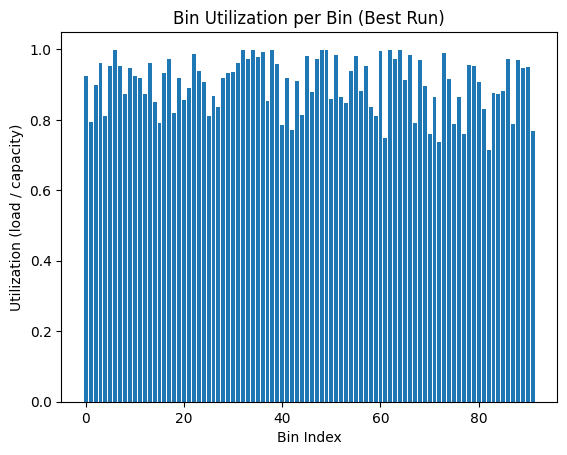

Total runtime for 20 runs: 18.03 seconds


In [50]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #7

Mean number of final bins 92.7
Median number of final bins 93.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.45825756949558394


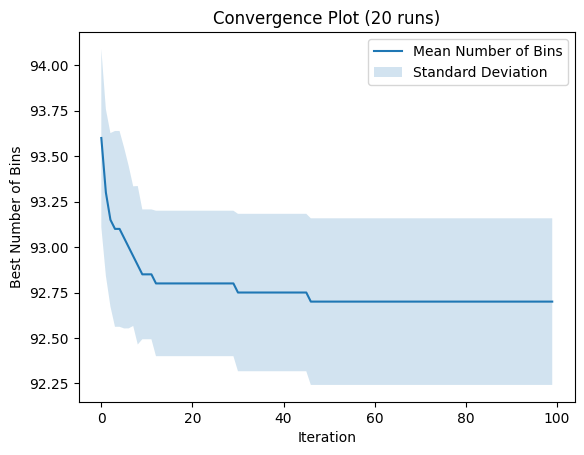

Mean number of unused capacity  970.0
Median number of unused capacity 1000.0
Best number of unused capacity 899.9999999999999
Worst number of unused capacity 1000.0000000000002
Standard deviation of unused capacity 45.8257569495584


Load Distribution for the best solution
The unused capacity for best solution 899.9999999999999


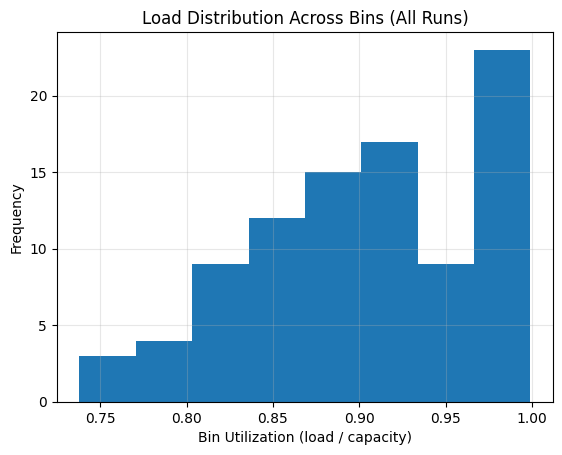

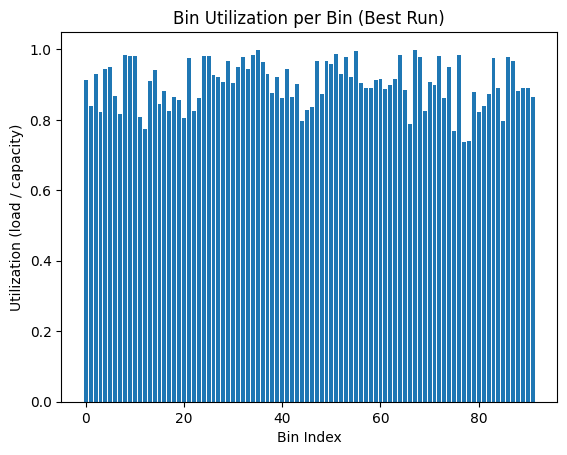

Total runtime for 20 runs: 12.26 seconds


In [51]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #7

Mean number of final bins 92.8
Median number of final bins 93.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.4


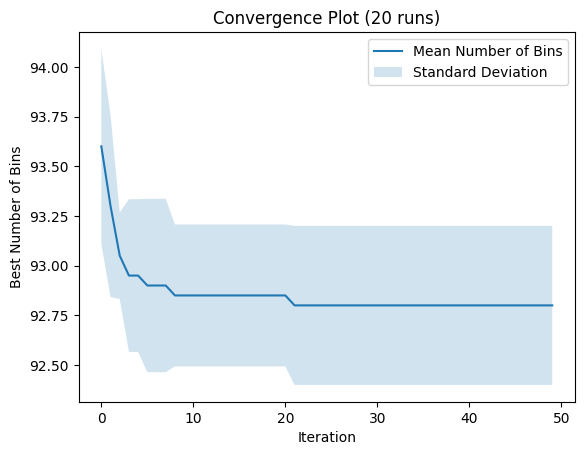

Mean number of unused capacity  980.0
Median number of unused capacity 1000.0
Best number of unused capacity 899.9999999999999
Worst number of unused capacity 1000.0000000000002
Standard deviation of unused capacity 40.000000000000014


Load Distribution for the best solution
The unused capacity for best solution 900.0


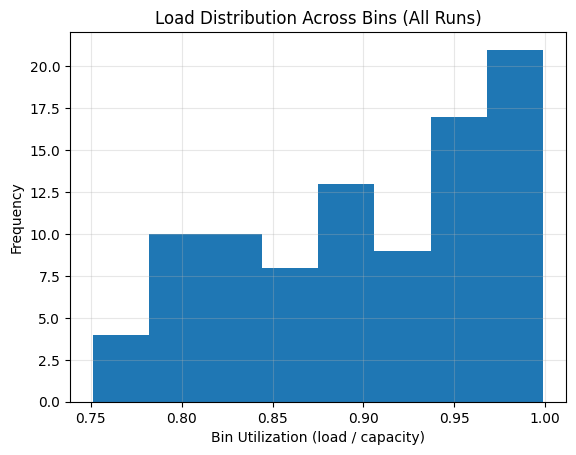

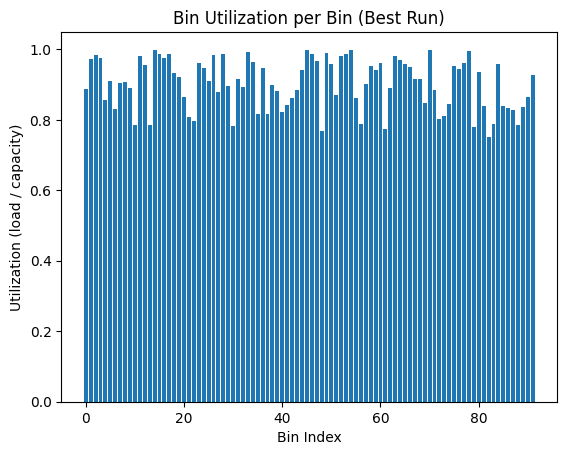

Total runtime for 20 runs: 6.37 seconds


In [52]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #7




 Alpha Value: 0.5
Mean number of final bins 92.45
Median number of final bins 92.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.4974937185533099


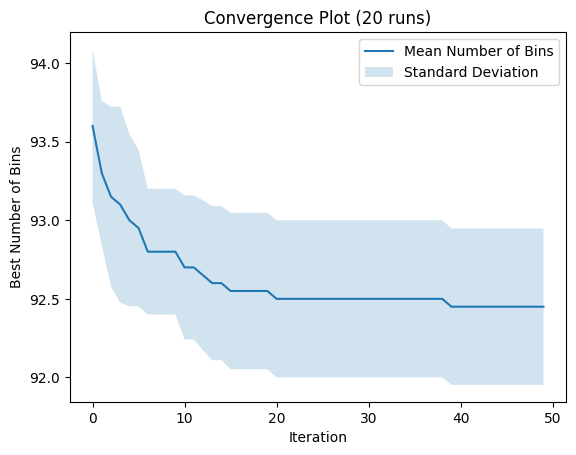

Mean number of unused capacity  945.0
Median number of unused capacity 900.0000000000001
Best number of unused capacity 899.9999999999999
Worst number of unused capacity 1000.0000000000001
Standard deviation of unused capacity 49.74937185533101


Load Distribution for the best solution
The unused capacity for best solution 900.0000000000001


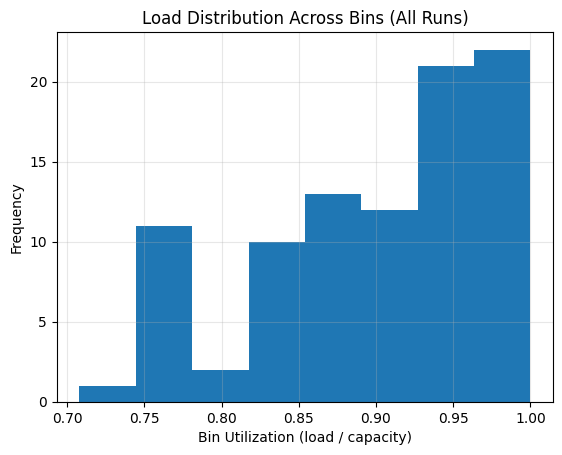

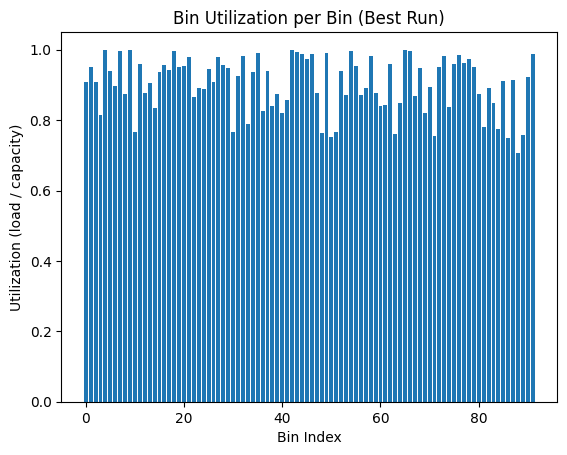

Total runtime for 20 runs: 6.25 seconds



 Alpha Value: 2
Mean number of final bins 92.85
Median number of final bins 93.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.3570714214271425


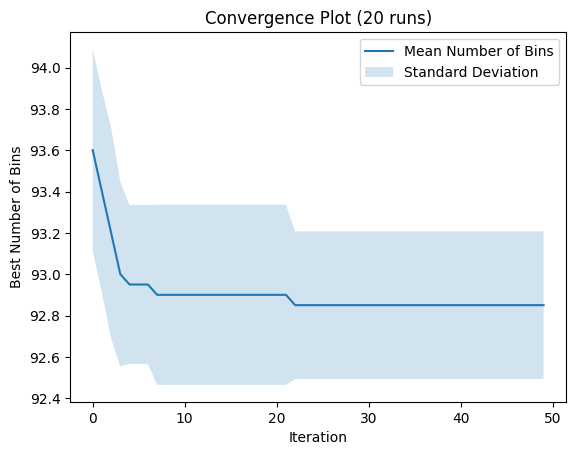

Mean number of unused capacity  985.0
Median number of unused capacity 1000.0
Best number of unused capacity 899.9999999999998
Worst number of unused capacity 1000.0000000000001
Standard deviation of unused capacity 35.707142142714275


Load Distribution for the best solution
The unused capacity for best solution 900.0


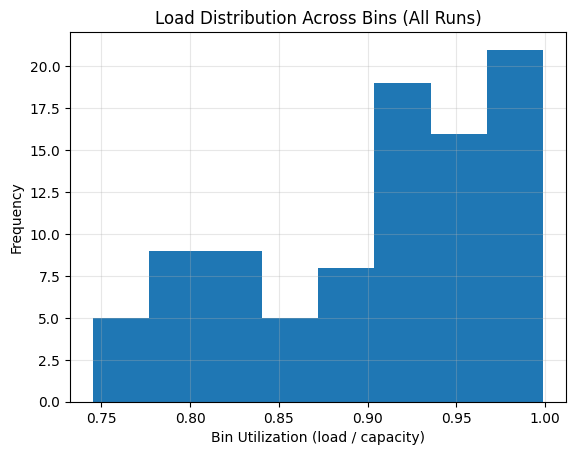

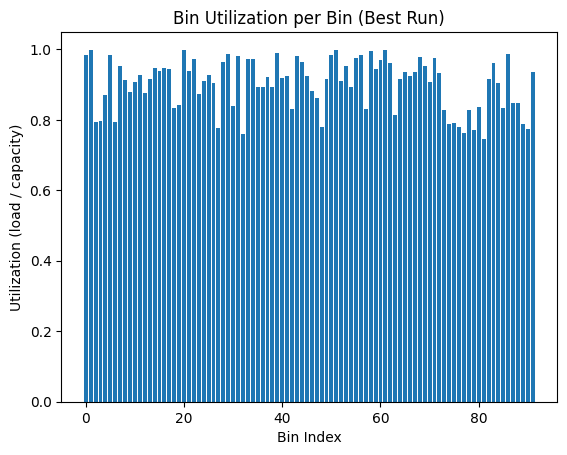

Total runtime for 20 runs: 6.33 seconds


In [53]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #7




 Alpha Value: 0.5
Mean number of final bins 92.45
Median number of final bins 92.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.4974937185533099


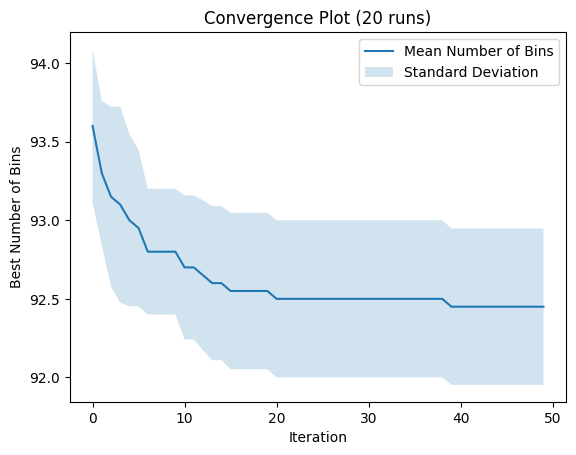

Mean number of unused capacity  945.0
Median number of unused capacity 900.0000000000001
Best number of unused capacity 899.9999999999999
Worst number of unused capacity 1000.0000000000001
Standard deviation of unused capacity 49.74937185533101


Load Distribution for the best solution
The unused capacity for best solution 900.0000000000001


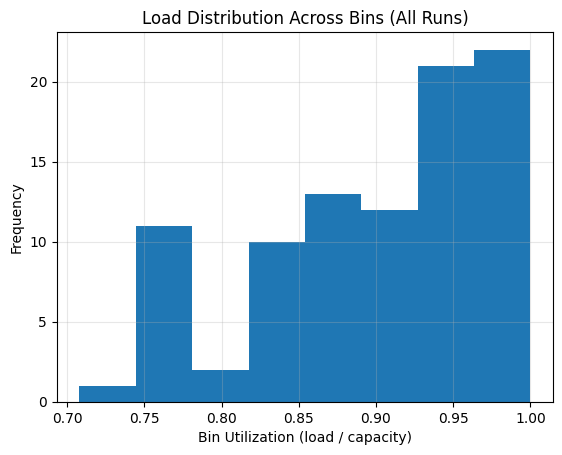

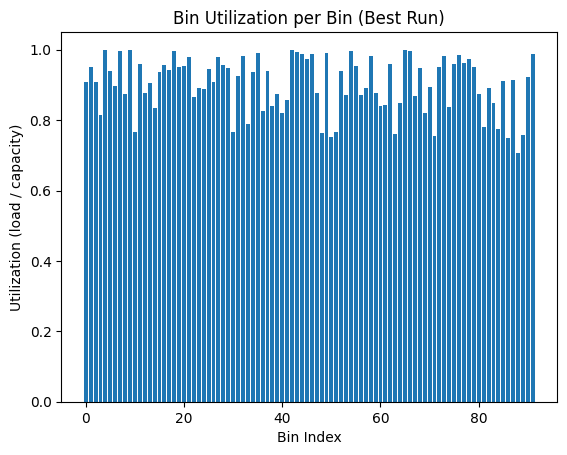

Total runtime for 20 runs: 6.20 seconds



 Alpha Value: 2
Mean number of final bins 92.85
Median number of final bins 93.0
Best number of final bins 92
Worst number of final bins 93
Standard deviation 0.3570714214271425


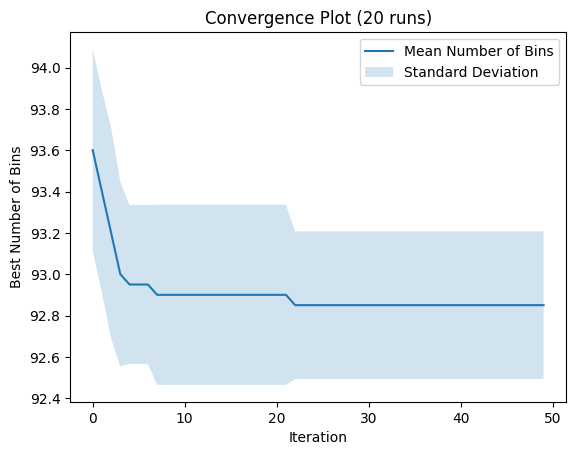

Mean number of unused capacity  985.0
Median number of unused capacity 1000.0
Best number of unused capacity 899.9999999999998
Worst number of unused capacity 1000.0000000000001
Standard deviation of unused capacity 35.707142142714275


Load Distribution for the best solution
The unused capacity for best solution 900.0


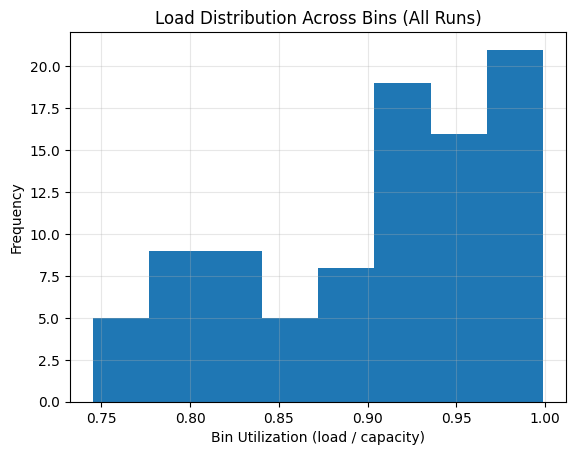

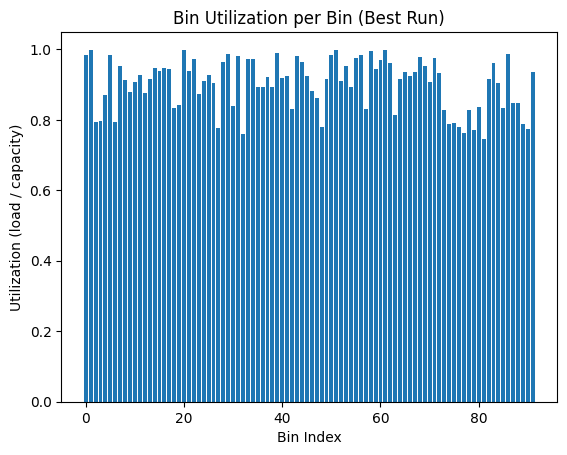

Total runtime for 20 runs: 6.28 seconds


In [54]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

# Problem #8

In [55]:
# Get the data


filename = "Data/1-D Bin Packing /binpack8.txt"

problems = read_binpack_file(filename)

## Select one problem from the instance

first_problem_key = list(problems.keys())[7]

capacity = problems[first_problem_key]["bin_capacity"]
num_items = problems[first_problem_key]["num_items"]
item_sizes = problems[first_problem_key]["item_sizes"]


print("Capacity: ", capacity)
print("Number of items: ", num_items)



Capacity:  100
Number of items:  501


Mean number of final bins 186.85
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 188
Standard deviation 0.5722761571129799


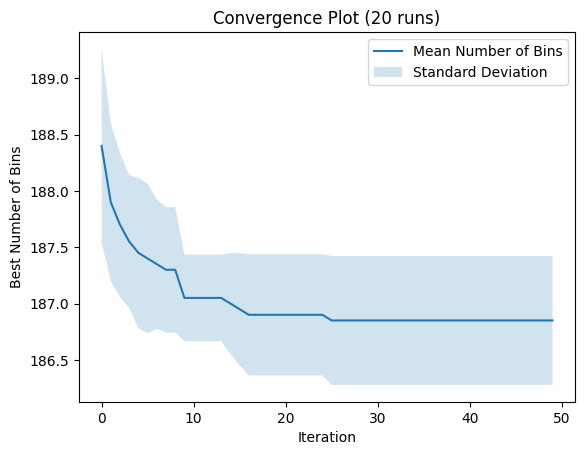

Mean number of unused capacity  1985.0
Median number of unused capacity 2000.0
Best number of unused capacity 1900.0
Worst number of unused capacity 2100.0
Standard deviation of unused capacity 57.227615711297965


Load Distribution for the best solution
The unused capacity for best solution 1900.0


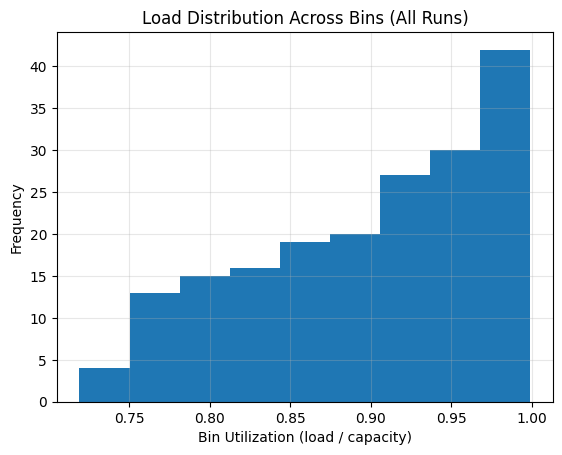

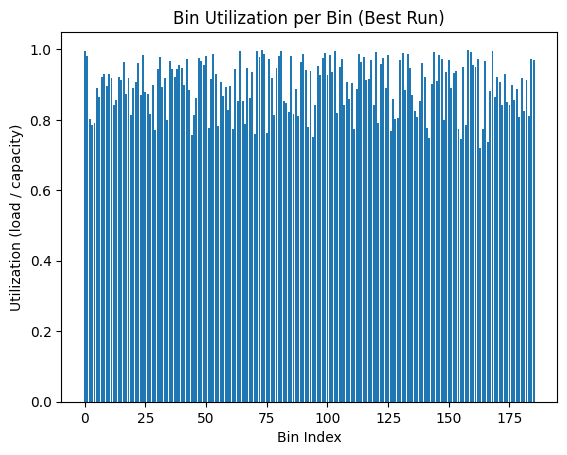

Total runtime for 20 runs: 23.05 seconds


In [56]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Ants Number #8

Mean number of final bins 186.5
Median number of final bins 186.5
Best number of final bins 186
Worst number of final bins 187
Standard deviation 0.5


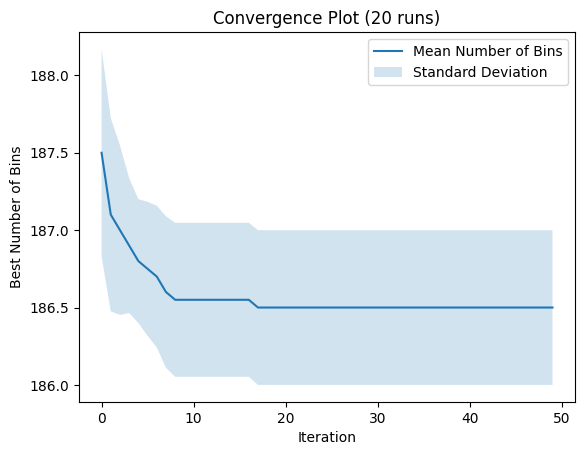

Mean number of unused capacity  1950.0
Median number of unused capacity 1950.0
Best number of unused capacity 1899.9999999999998
Worst number of unused capacity 2000.0
Standard deviation of unused capacity 49.99999999999998


Load Distribution for the best solution
The unused capacity for best solution 1899.9999999999998


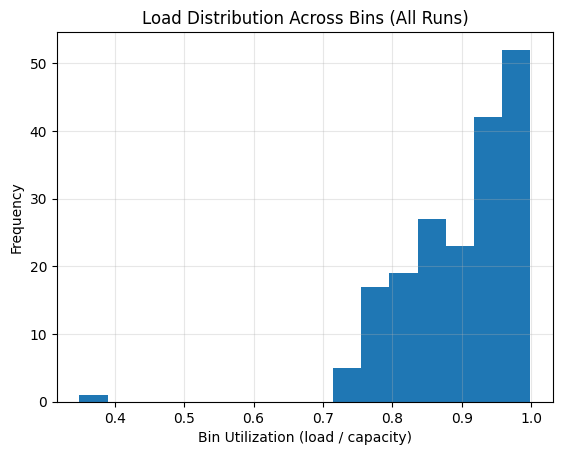

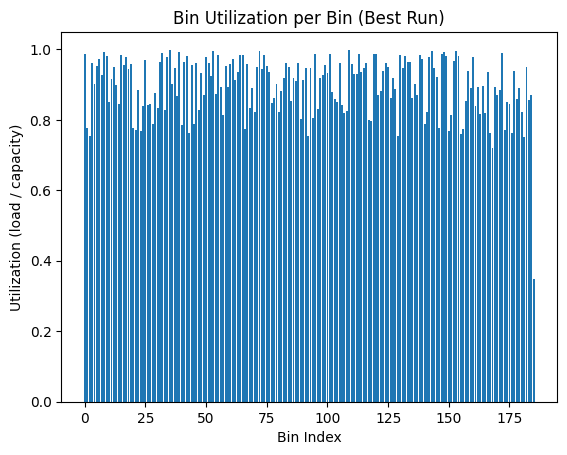

Total runtime for 20 runs: 68.56 seconds


In [57]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 15, n_best = 5, n_iterations = 50, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Increase Iterations #8

Mean number of final bins 186.85
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 188
Standard deviation 0.5722761571129799


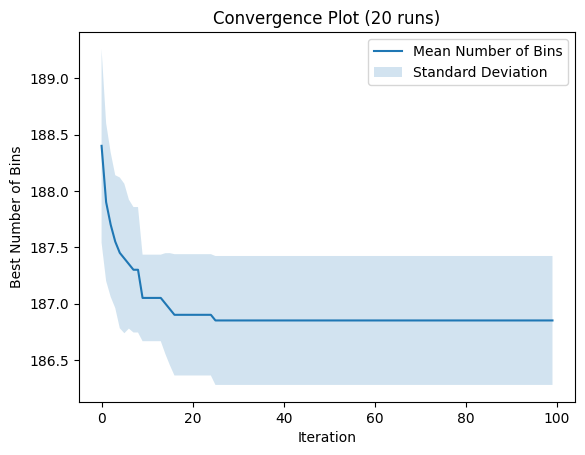

Mean number of unused capacity  1985.0
Median number of unused capacity 2000.0
Best number of unused capacity 1900.0
Worst number of unused capacity 2100.0
Standard deviation of unused capacity 57.227615711297965


Load Distribution for the best solution
The unused capacity for best solution 1900.0


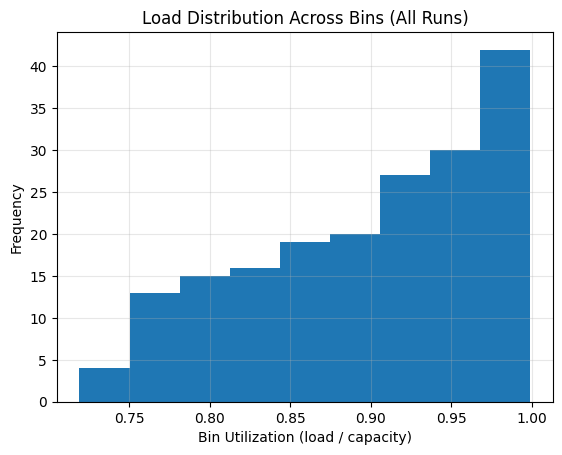

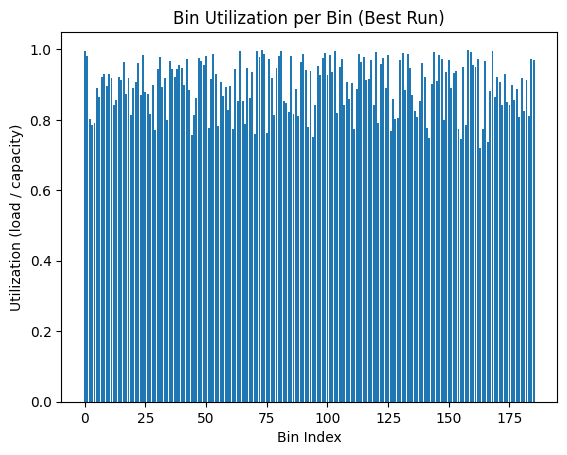

Total runtime for 20 runs: 46.96 seconds


In [58]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 100, decay = 0.9, alpha = 1, beta = 1, n_runs = 20)

### Decrease Decay #8

Mean number of final bins 187.35
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 188
Standard deviation 0.5722761571129799


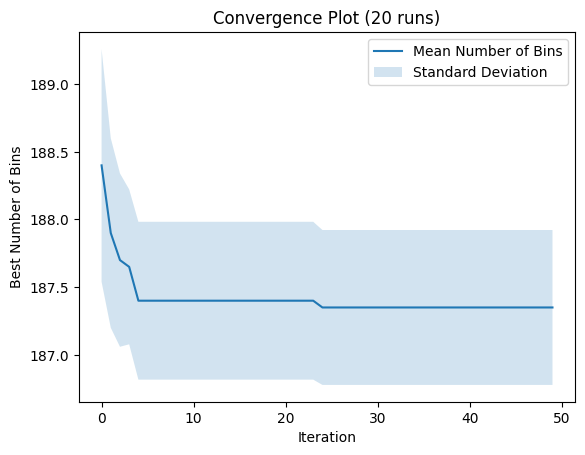

Mean number of unused capacity  2035.0
Median number of unused capacity 2000.0
Best number of unused capacity 1899.9999999999998
Worst number of unused capacity 2100.0
Standard deviation of unused capacity 57.22761571129799


Load Distribution for the best solution
The unused capacity for best solution 1899.9999999999998


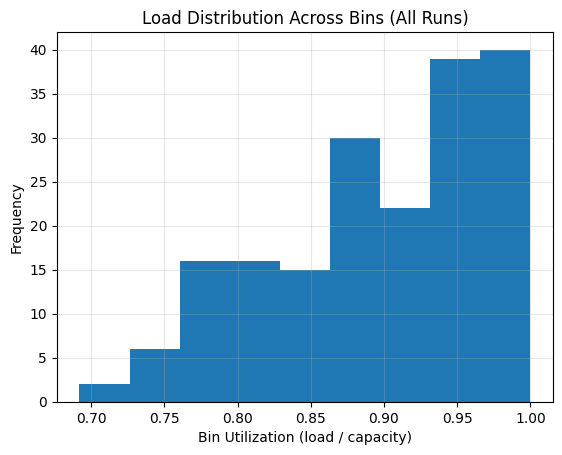

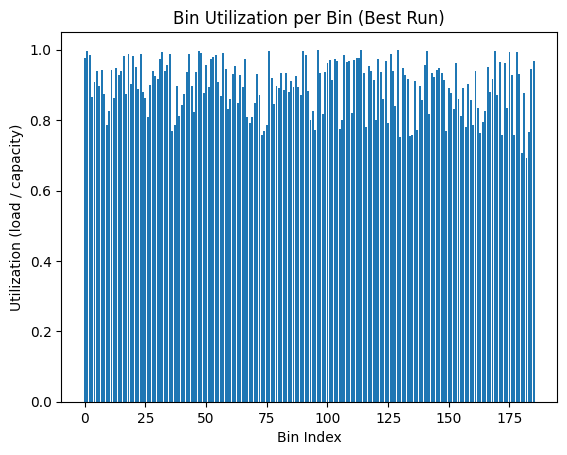

Total runtime for 20 runs: 23.46 seconds


In [59]:
run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.5, alpha = 1, beta = 1, n_runs = 20)

### Modify Alpha #8




 Alpha Value: 0.5
Mean number of final bins 186.8
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 187
Standard deviation 0.4000000000000001


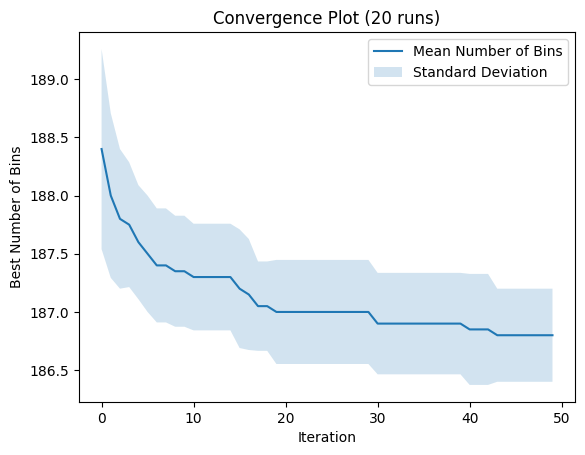

Mean number of unused capacity  1980.0
Median number of unused capacity 2000.0
Best number of unused capacity 1899.9999999999998
Worst number of unused capacity 2000.0000000000002
Standard deviation of unused capacity 40.000000000000036


Load Distribution for the best solution
The unused capacity for best solution 1900.0


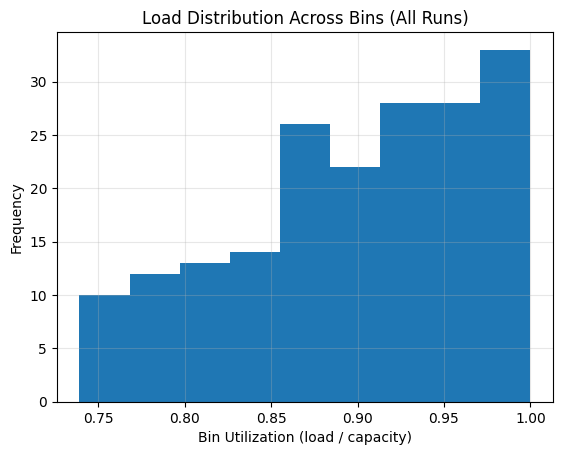

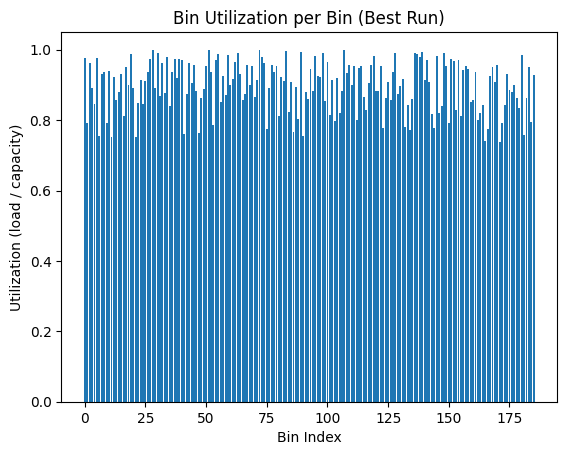

Total runtime for 20 runs: 23.73 seconds



 Alpha Value: 2
Mean number of final bins 187.1
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 188
Standard deviation 0.6244997998398398


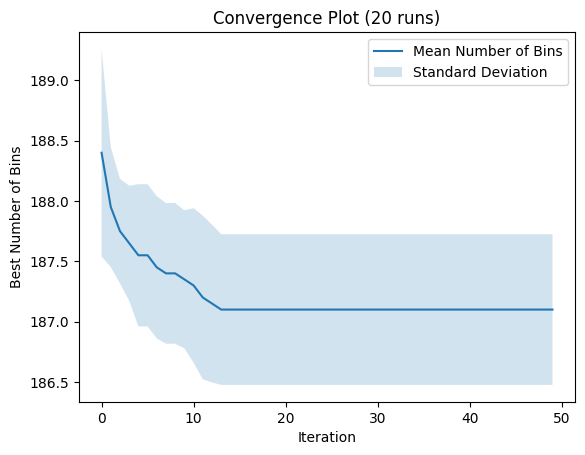

Mean number of unused capacity  2010.0
Median number of unused capacity 2000.0
Best number of unused capacity 1899.9999999999998
Worst number of unused capacity 2100.0000000000005
Standard deviation of unused capacity 62.449979983984036


Load Distribution for the best solution
The unused capacity for best solution 1900.0


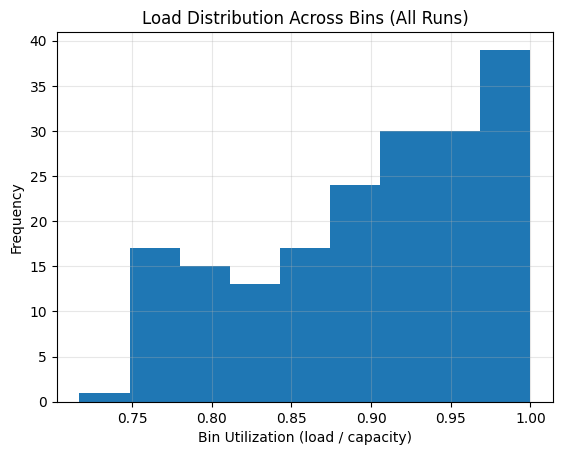

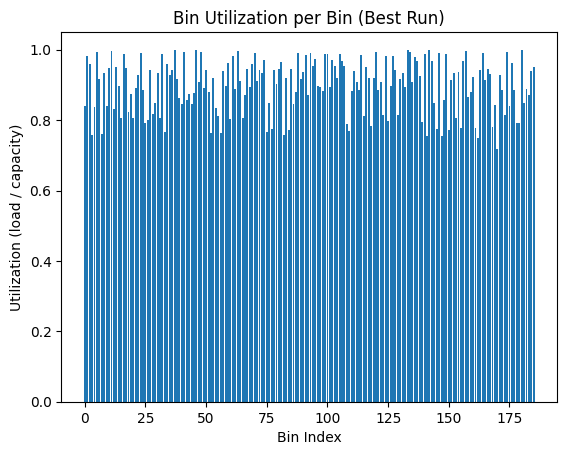

Total runtime for 20 runs: 23.99 seconds


In [60]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)

### Modify Beta #8




 Alpha Value: 0.5
Mean number of final bins 186.8
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 187
Standard deviation 0.4000000000000001


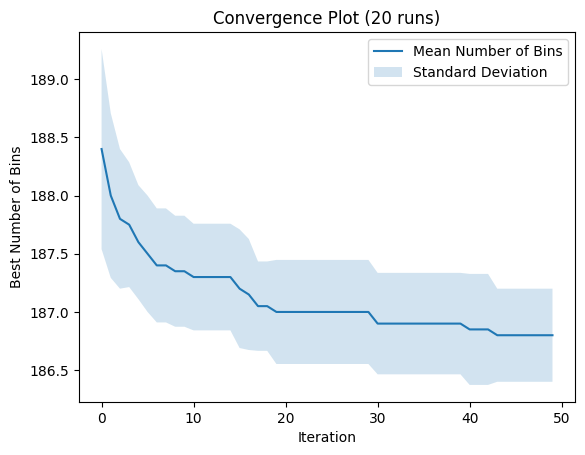

Mean number of unused capacity  1980.0
Median number of unused capacity 2000.0
Best number of unused capacity 1899.9999999999998
Worst number of unused capacity 2000.0000000000002
Standard deviation of unused capacity 40.000000000000036


Load Distribution for the best solution
The unused capacity for best solution 1900.0


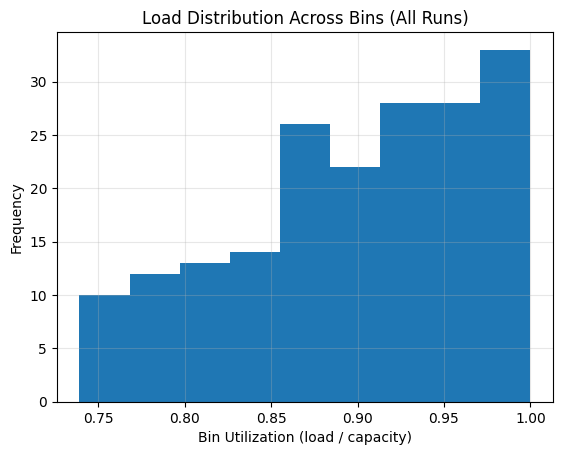

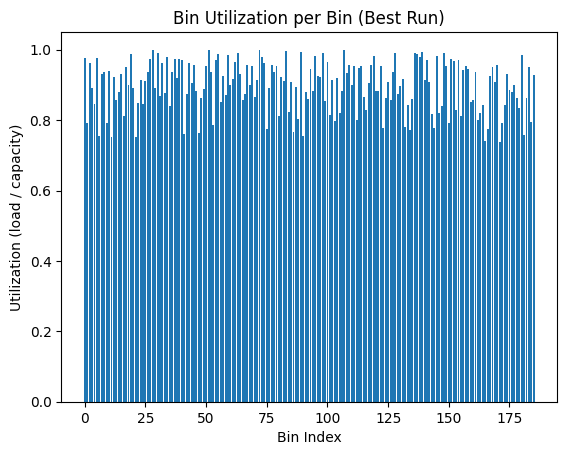

Total runtime for 20 runs: 23.35 seconds



 Alpha Value: 2
Mean number of final bins 187.1
Median number of final bins 187.0
Best number of final bins 186
Worst number of final bins 188
Standard deviation 0.6244997998398398


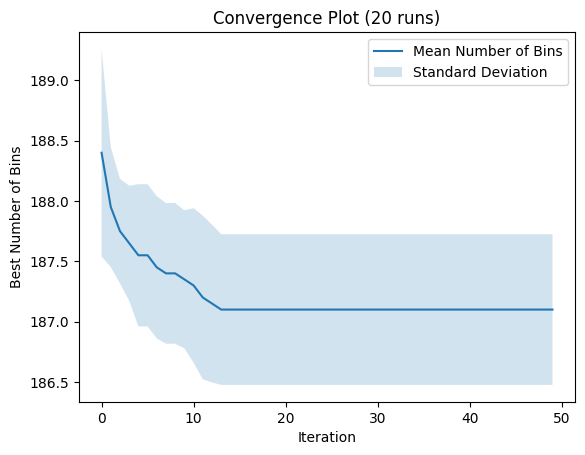

Mean number of unused capacity  2010.0
Median number of unused capacity 2000.0
Best number of unused capacity 1899.9999999999998
Worst number of unused capacity 2100.0000000000005
Standard deviation of unused capacity 62.449979983984036


Load Distribution for the best solution
The unused capacity for best solution 1900.0


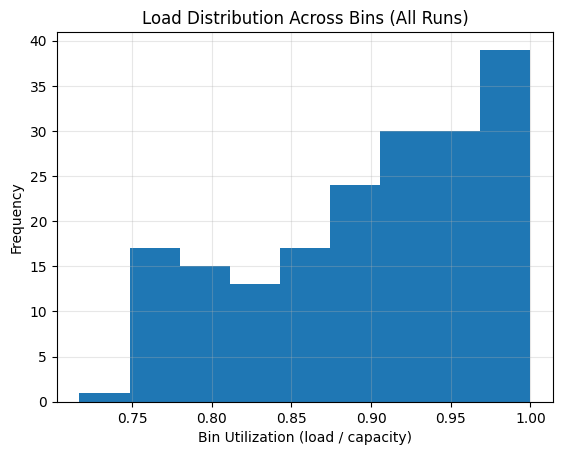

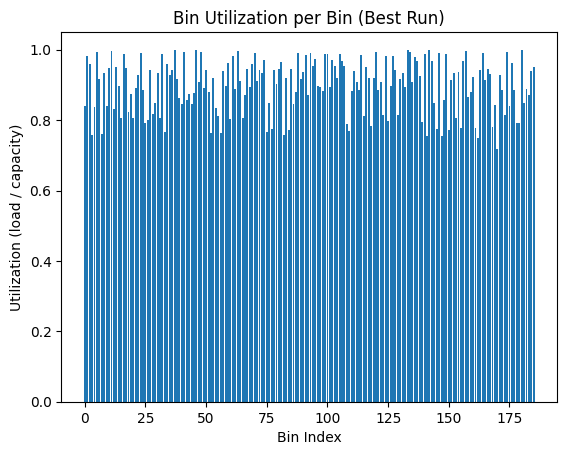

Total runtime for 20 runs: 24.13 seconds


In [61]:

alphas = [0.5, 2]
for alpha in alphas:
    print("\n\n\n Alpha Value:", alpha)
    run_plot_ACO(num_items = num_items,capacity=capacity, items=item_sizes, n_ants = 5, n_best = 5, n_iterations = 50, decay = 0.9, alpha = alpha, beta = 1, n_runs = 20)